- 출처 : 금융 파이썬 쿡북
# 머신러닝으로 디폴트 찾기

* 사용되는 데이터 셋은 2005년 10월 대만 은행에서 수집 
* 이 연구는 그 당시 점점 더 많은 은행들이 기꺼이 고객들에게 현금 및 신용카드을 발급하고 있는 사실에서 비롯되었다. 
* 상환 능력에 관계없이 점점 더 많은 사람들이 상당한 양의 부채를 축적해 결국 디폴트를 초래했음 
* 당시 연구 목표는 과거 상환 내역과 함께 고객에 대한 몇 가지 기본정보(성별, 연령, 교육 수준)를 사용해 디폴트 가능성이 높은 사람을 예측하는 것 
* 6개월의 상환내역(2005년 4월 ~ 9월)을 사용해 고객이 2005년 10월에 디폴트를 할지 여부를 예측하려고 한다. 

In [1]:
import pandas as pd
import numpy as np
import random

# 데이티 읽기 및 유형 관리 

## 데이터셋에서 확인하기 

* separator 문자는 무엇인가?
* 별도 처리해야 하는 특수 문자가 존재하는가?
* 누락된 값(결측치)이 있는가? 그렇다면 어떻게 처리해야하나?
* 파일에 있는 변수 유형(float, integer, string)은 무엇인가? 
    * 이 정보를 바탕으로 메모리 최적화도 할 수 있다.

In [2]:
df = pd.read_csv('credit_card_default.csv', index_col=0, na_values='')
print(f'The DataFrame has {len(df)} rows and {df.shape[1]} columns.')
df.head()

The DataFrame has 30000 rows and 24 columns.


,limit_bal,sex,education,marriage,age,payment_status_sep,payment_status_aug,payment_status_jul,payment_status_jun,payment_status_may,...,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,previous_payment_jul,previous_payment_jun,previous_payment_may,previous_payment_apr,default_payment_next_month
0,20000,Female,University,Married,24.0,Payment delayed 2 months,Payment delayed 2 months,Payed duly,Payed duly,Unknown,...,0,0,0,0,689,0,0,0,0,1
1,120000,Female,University,Single,26.0,Payed duly,Payment delayed 2 months,Unknown,Unknown,Unknown,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,Female,University,Single,34.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,Female,University,Married,37.0,Unknown,Unknown,Unknown,Unknown,Unknown,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,Male,University,Married,57.0,Payed duly,Unknown,Payed duly,Unknown,Unknown,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


* Target(y값) 추출

In [3]:
X = df.copy()
y = X.pop('default_payment_next_month')

In [4]:
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age',
       'payment_status_sep', 'payment_status_aug', 'payment_status_jul',
       'payment_status_jun', 'payment_status_may', 'payment_status_apr',
       'bill_statement_sep', 'bill_statement_aug', 'bill_statement_jul',
       'bill_statement_jun', 'bill_statement_may', 'bill_statement_apr',
       'previous_payment_sep', 'previous_payment_aug', 'previous_payment_jul',
       'previous_payment_jun', 'previous_payment_may', 'previous_payment_apr'],
      dtype='object')

## 컬럼 설명
* limit_bal : 대출 총액(대만 달러)
* sex : 성별 
* education : 학력 
* marriage : 결혼상태 
* age : 나이 
* payment_status_{month} : 이전 6개의 상환 현황 
* bill_statement_{month} : 이전 6개의 청구 금액(대만 달러)
* previous_payment_{month} : 이전 6개월에서 직전 월 상환 현황(대만 달러)

## 데이터 형태 확인 
* pandas는 컬럼의 데이터 타입을 자동으로 설정한다.
* 데이터프레임의 용량이 크거나 분석하는 컴퓨터의 메모리 용량이 작을 경우 컬럼의 데이터 타입을 변경하면 메모리를 절약할 수 있다. 

In [5]:
df.dtypes

limit_bal                       int64
sex                            object
education                      object
marriage                       object
age                           float64
payment_status_sep             object
payment_status_aug             object
payment_status_jul             object
payment_status_jun             object
payment_status_may             object
payment_status_apr             object
bill_statement_sep              int64
bill_statement_aug              int64
bill_statement_jul              int64
bill_statement_jun              int64
bill_statement_may              int64
bill_statement_apr              int64
previous_payment_sep            int64
previous_payment_aug            int64
previous_payment_jul            int64
previous_payment_jun            int64
previous_payment_may            int64
previous_payment_apr            int64
default_payment_next_month      int64
dtype: object

### 메모리 사용량 확인하기

In [6]:
# 실제로 메모리를 얼마나 사용중인가 확인하는 함수
def get_df_memory_usage(df, top_columns=5):
    '''
    Function for quick analysis of a pandas DataFrame's memory usage.
    It prints the top `top_columns` columns in terms of memory usage 
    and the total usage of the DataFrame.
    
    Parameters
    ------------
    df : pd.DataFrame
        DataFrame to be inspected
    top_columns : int
        Number of top columns (in terms of memory used) to display
    '''
    print('Memory usage ----')
    memory_per_column = df.memory_usage(deep=True) / 1024 ** 2
    print(f'Top {top_columns} columns by memory (MB):')
    print(memory_per_column.sort_values(ascending=False) \
                           .head(top_columns))
    print(f'Total size: {memory_per_column.sum():.4f} MB')

In [8]:
get_df_memory_usage(df, 55)

Memory usage ----
Top 55 columns by memory (MB):
education                     1.965001
payment_status_sep            1.954342
payment_status_aug            1.920288
payment_status_jul            1.916343
payment_status_jun            1.904229
payment_status_apr            1.897395
payment_status_may            1.895020
marriage                      1.810966
sex                           1.775459
previous_payment_jun          0.228882
previous_payment_aug          0.228882
previous_payment_jul          0.228882
Index                         0.228882
previous_payment_may          0.228882
bill_statement_apr            0.228882
previous_payment_apr          0.228882
previous_payment_sep          0.228882
bill_statement_sep            0.228882
bill_statement_may            0.228882
bill_statement_jun            0.228882
bill_statement_jul            0.228882
bill_statement_aug            0.228882
limit_bal                     0.228882
age                           0.228882
default_payment

* type이 object인 컬럼을 대상으로 category(범주형) 데이터 타입으로 변경하여 메모리를 절약할 수 있다. 

In [9]:
df_cat = df.copy()
object_columns = df_cat.select_dtypes(include='object').columns
df_cat[object_columns] = df_cat[object_columns].astype('category')

## read_csv를 사용하여 범주형 데이터 읽기
* 처음부터 read_csv 메서드를 사용해서 데이터를 읽을 때 컬럼 타입을 지정해서 읽으면 해당 타입으로 데이터프레임이 만들어 진다. 

In [11]:
get_df_memory_usage(df_cat, 55)

Memory usage ----
Top 55 columns by memory (MB):
Index                         0.228882
bill_statement_aug            0.228882
previous_payment_apr          0.228882
previous_payment_may          0.228882
previous_payment_jun          0.228882
previous_payment_jul          0.228882
previous_payment_aug          0.228882
previous_payment_sep          0.228882
bill_statement_apr            0.228882
bill_statement_may            0.228882
bill_statement_jun            0.228882
bill_statement_jul            0.228882
bill_statement_sep            0.228882
limit_bal                     0.228882
age                           0.228882
default_payment_next_month    0.228882
payment_status_jun            0.029638
payment_status_jul            0.029638
payment_status_aug            0.029638
payment_status_sep            0.029638
payment_status_apr            0.029562
payment_status_may            0.029562
education                     0.029032
marriage                      0.028894
sex            

In [12]:
column_dtypes = {'education': 'category', 
                 'marriage': 'category', 
                 'sex': 'category',
                 'payment_status_sep': 'category', 
                 'payment_status_aug': 'category', 
                 'payment_status_jul': 'category',       
                 'payment_status_jun': 'category', 
                 'payment_status_may': 'category', 
                 'payment_status_apr': 'category'}
df_cat2 = pd.read_csv('credit_card_default.csv', index_col=0, 
                      na_values='', dtype=column_dtypes)

* 두 객체가 동일한지 확인 

In [13]:
df_cat.equals(df_cat2)

True

# 탐색적 데이터 분석(Exploratory Data Analysis)

* 실제로 어떤 종류의 데이터를 갖고 있으며 다른 유형을 어떻게 다뤄야 하는가?
* 변수의 분포는 무엇인가?
    * 데이터에 특이값이 있는가? 어떻게 처리할 수 있는가?
    * 변환이 필요한가? 예를 들어, 일부 모델은 정규 분포 변수와 더 잘 작동하거나 로그 변환과 같은 기술을 사용할 수 있다.
    * 분포는 그룹마다 다른가?(예: 성별 또는 교육 수준)
* 데이터가 누락된 경우가 있는가? 얼마나 빈번하고 어떤 변수에 있는가?
* 일부 변수 간에 선형(상관) 관계가 있는가?
* 기존 변수 집합을 사용해 새 특징을 생성할 수 있는가? 타임 스탬프에서 시간/분, 날짜에서 요일 등을 예로 들수 있다
* 분석과 관련이 없기 때문에 제거할 수 있는 변수가 있는가? 무작위로 생성된 고객 식별자를 예로 들 수 있다. 

## Import the libraries 하기

In [16]:
import pandas as pd
import seaborn as sns
import numpy as np

## 수치형 데이터에 대한 기술 통계값을 구한다.
* describe()를 사용하여 수치형 데이터의 개수, 평균, 최소/최대 및 사분위수와 같은 요약 통계 출력
* 이러한 지표를 검사해 특정 특징의 값 범위 또는 분포가 왜곡됐는지 평균값과 중앙값의 차이를 확인해 추정할 수 있다.
* 음수나 매우 작은 연령 등 가능한 범위를 벗어난 값을 쉽게 발견할 수 있다. 

In [17]:
df.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
limit_bal,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
age,29850.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
bill_statement_sep,30000.0,51223.33,73635.86,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_statement_aug,30000.0,49179.08,71173.77,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_statement_jul,30000.0,47013.15,69349.39,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_statement_jun,30000.0,43262.95,64332.86,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_statement_may,30000.0,40311.40,60797.16,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_statement_apr,30000.0,38871.76,59554.11,-339603.0,1256.00,17071.0,49198.25,961664.0
previous_payment_sep,30000.0,5663.58,16563.28,0.0,1000.00,2100.0,5006.00,873552.0
previous_payment_aug,30000.0,5921.16,23040.87,0.0,833.00,2009.0,5000.00,1684259.0


## 범주형 변수에 대한 기술 통계량을 구한다. 
    * include 매개변수에 'object' 인수를 추가하면 범주 특징을 개별적으로 출력할 수 있다. 

In [18]:
df.describe(include='object').transpose()

,count,unique,top,freq
sex,29850,2,Female,18027
education,29850,4,University,13960
marriage,29850,3,Single,15891
payment_status_sep,30000,10,Unknown,17496
payment_status_aug,30000,10,Unknown,19512
payment_status_jul,30000,10,Unknown,19849
payment_status_jun,30000,10,Unknown,20803
payment_status_may,30000,9,Unknown,21493
payment_status_apr,30000,9,Unknown,21181


## 데이터 시각화 
* 나이 분포를 도식화하여 추가적으로 성별로 분할하기
* 단일 특징의 분포를 검사하는 보편적인 방법중 하나 
* hist = True를 사용하면 히스토그램을 만들수 있다. 

In [43]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [7,4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

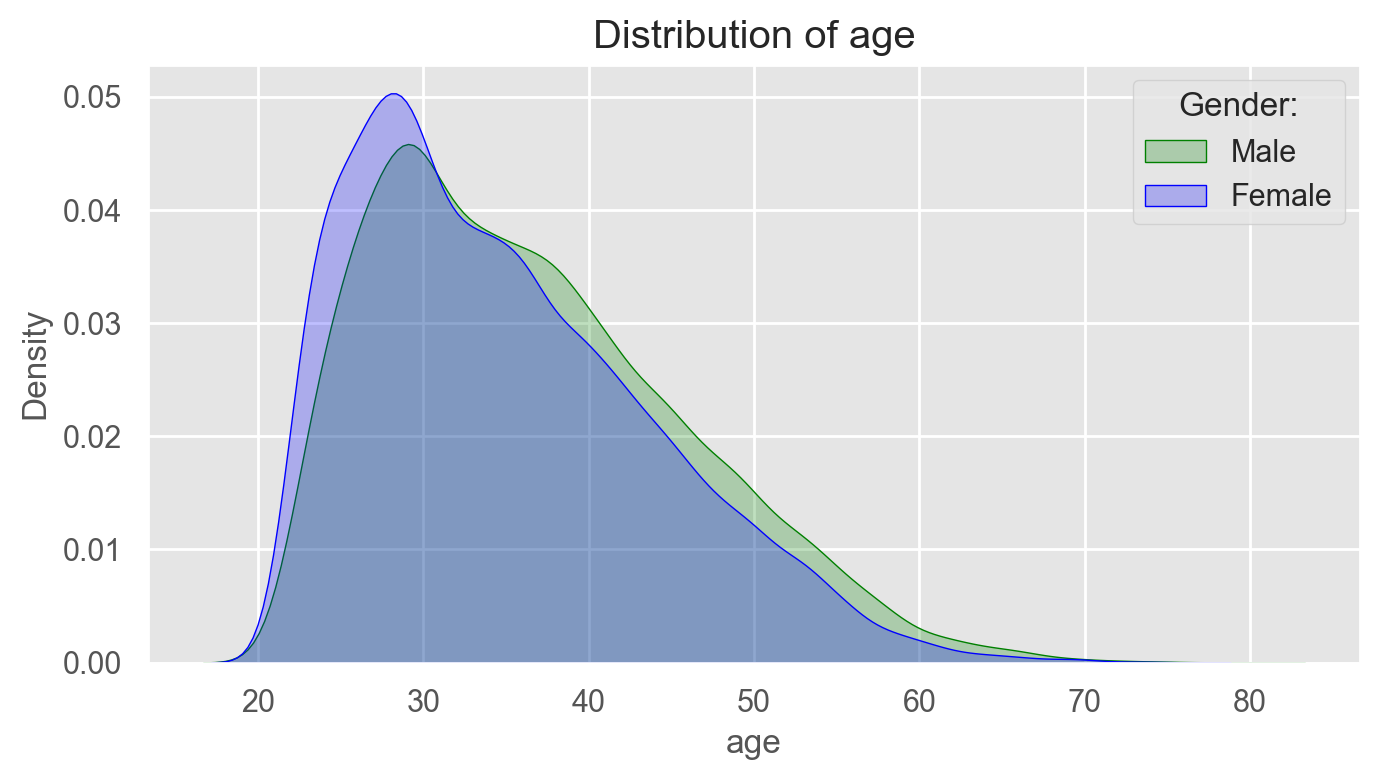

In [44]:
fig, ax = plt.subplots()
sns.kdeplot(df.loc[df.sex=='Male', 'age'].dropna(), 
             color='green', fill=True,
             ax=ax, label='Male')
sns.kdeplot(df.loc[df.sex=='Female', 'age'].dropna(), 
             color='blue', fill=True,
             ax=ax, label='Female')
ax.set_title('Distribution of age')
ax.legend(title='Gender:')

plt.tight_layout()
# plt.savefig('images/ch8_im5.png')
plt.show()

* 그림을 분석해보면 성별 분포의 모양에 큰 차이가 없다. 여성 샘픔은 평균적으로 약간 더 젊다 

### 선택된 변수에 대해 pairplot을 도식화한다. 
* 대각선은 일변량 히스토그램을 나타내고, 비대각은 두 변수의 산점도를 나타낸다. 
* 이 방법으로 두 변수 간에 관계가 있는지 확인할 수 있다. 

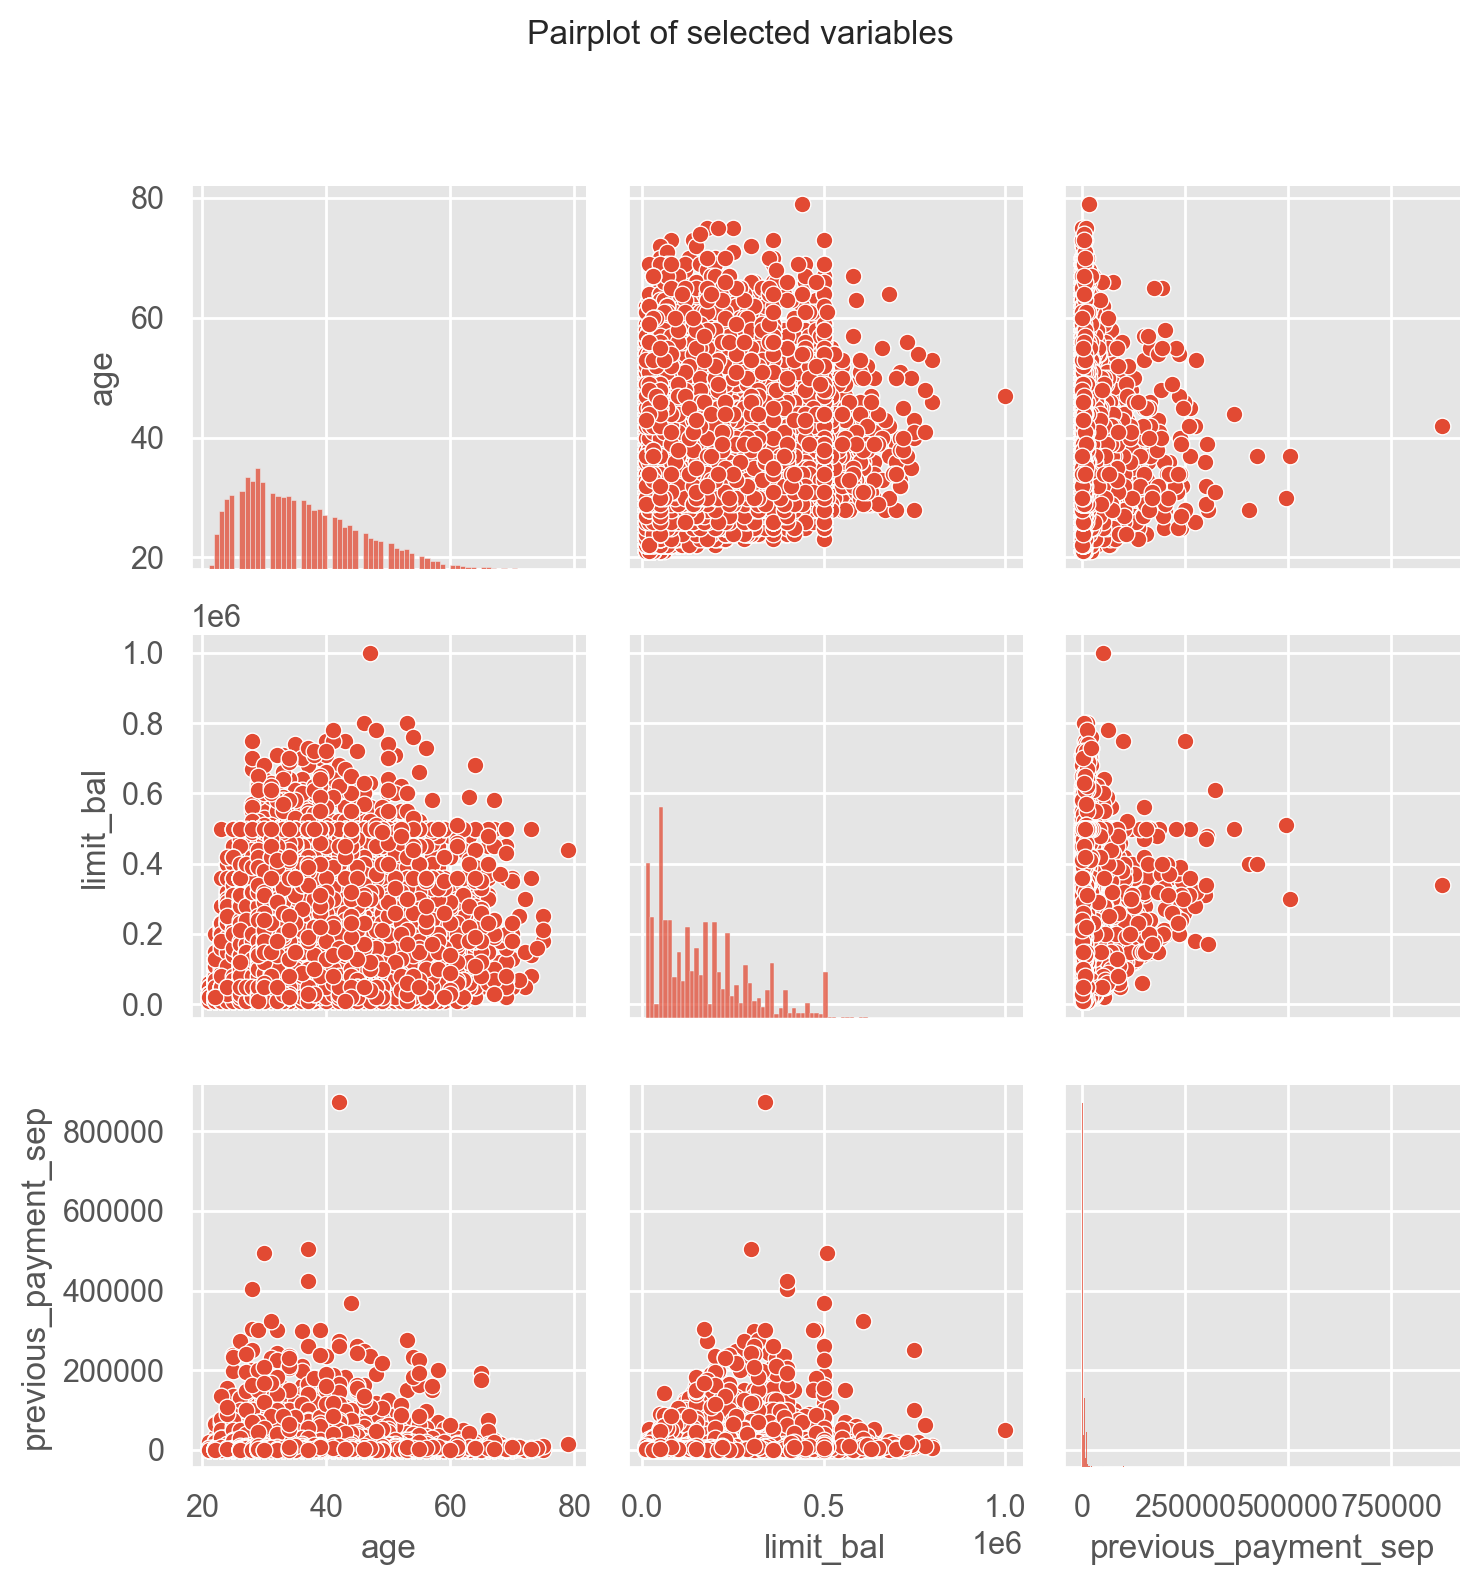

In [45]:
pair_plot = sns.pairplot(df[['age', 'limit_bal', 'previous_payment_sep']])
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05)

plt.tight_layout()
# plt.savefig('images/ch8_im6.png', bbox_inches='tight')
plt.show()

### 상관관계 히트맵(heatmap)을 그리는 함수를 정의하고 실행
    * 상삼각(upper triangluar) 행렬을 대각 행렬과 함께 마스킹하고자 몇 가지 연산을 사용하여 출력
    * 상관관계를 계산하고자 피어슨 상관계수를 사용(corr()메서드)

In [51]:
def plot_correlation_matrix(corr_mat):
    '''
    Function for plotting the correlation heatmap. It masks the irrelevant fields.
    
    Parameters
    ----------
    corr_mat : pd.DataFrame
        Correlation matrix of the features.
    '''
    
    # temporarily change style
    sns.set(style='white')
    sns.set(font_scale=0.5)
    # mask the upper triangle
    mask = np.zeros_like(corr_mat, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    # set up the matplotlib figure
    fig, ax = plt.subplots()
    # set up custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    # plot the heatmap
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5,
                cbar_kws={'shrink': .5}, ax=ax)
    ax.set_title('Correlation Matrix', fontsize=8)
    # change back to darkgrid style
    sns.set(style='darkgrid')

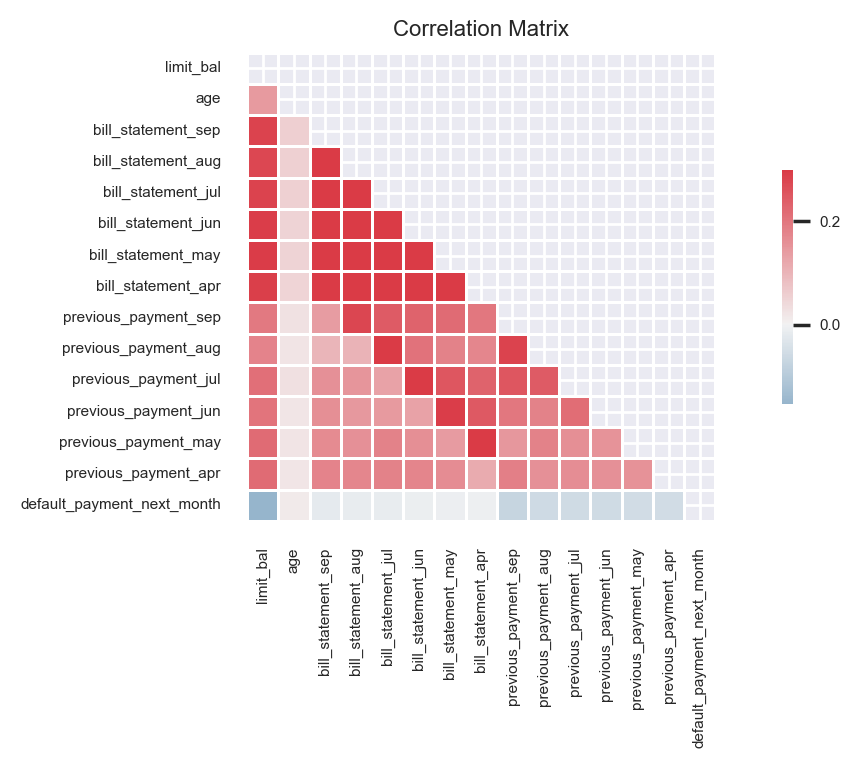

In [52]:
corr_mat = df.select_dtypes(include='number').corr()    
plot_correlation_matrix(corr_mat)

plt.tight_layout()
#plt.savefig('images/ch8_im7.png')
plt.show()

In [53]:
df.select_dtypes(include='number').corr()[['default_payment_next_month']]

,default_payment_next_month
limit_bal,-0.153520
age,0.014491
bill_statement_sep,-0.019644
bill_statement_aug,-0.014193
bill_statement_jul,-0.014076
bill_statement_jun,-0.010156
bill_statement_may,-0.006760
bill_statement_apr,-0.005372
previous_payment_sep,-0.072929
previous_payment_aug,-0.058579


### 각 성별과 교육 수준에 따른 잔고 한도 분석을 도식화
* 바이올린(violin) 플롯을 사용하여 도식화 
* 카테고리값에 따른 분포의 실제 데이터 또는 전체 형상을 보여주는 장점을 가짐 
* 중앙값은 흰색 점으로 표시 
* 바이올린 중심에는 검은색 막대로 표시되는 사분위수 범위(IQR)가 나타난다. 
* 막대에서 뻗은 검은색 선으로 표시되는 인접 및 하한 값. 하부 인접 값은 제1시분위수 -1.5 IQR로 정의되고, 상부는 세 번째 사분위수 + 1.5IQR로 정의 
* 바이올린 도면은 박스 플롯과 커널 밀도 추정 플롯의 조합
8 바이올린 플롯의 장점은 분포의 모양을 명확하게 볼 수 있다는 점
* 대학원 교육 범주의 잔고 한도 바이올린과 같은 멀티모달 분포를 다룰 때 특히 유용

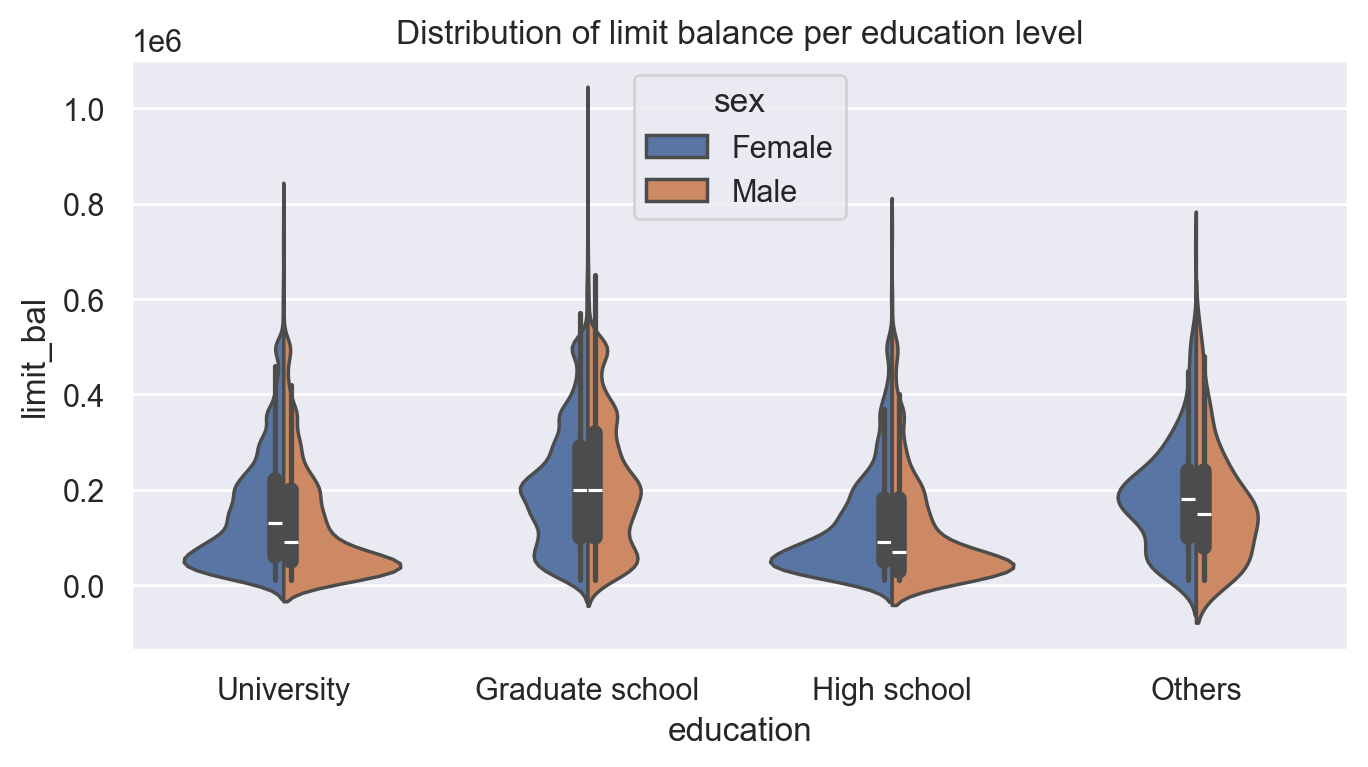

In [57]:
ax = sns.violinplot(x='education', y='limit_bal', 
                    hue='sex', split=True, data=df)
ax.set_title('Distribution of limit balance per education level', 
             fontsize=12)

plt.tight_layout()
# plt.savefig('images/ch8_im8.png')
plt.show()

* 대학원 교육 수준을 가진 그룹에서 가장 큰 잔고가 나타난다. 
* 분포 형태는 교육 수준에 따라 다르다. 대학원 수준은 기타 범주와 비슷하지만 고등학교 수준은 대학 수준과 비슷하다. 
* 일반적으로 성별 사이에는 차이가 거의 없다. 

### 성별 교육 수준별 목표 변수의 분포를 조사 
* countplot을 사용해 각 성별에 대해 가능한 두 결과의 발생 횟수를 표시 

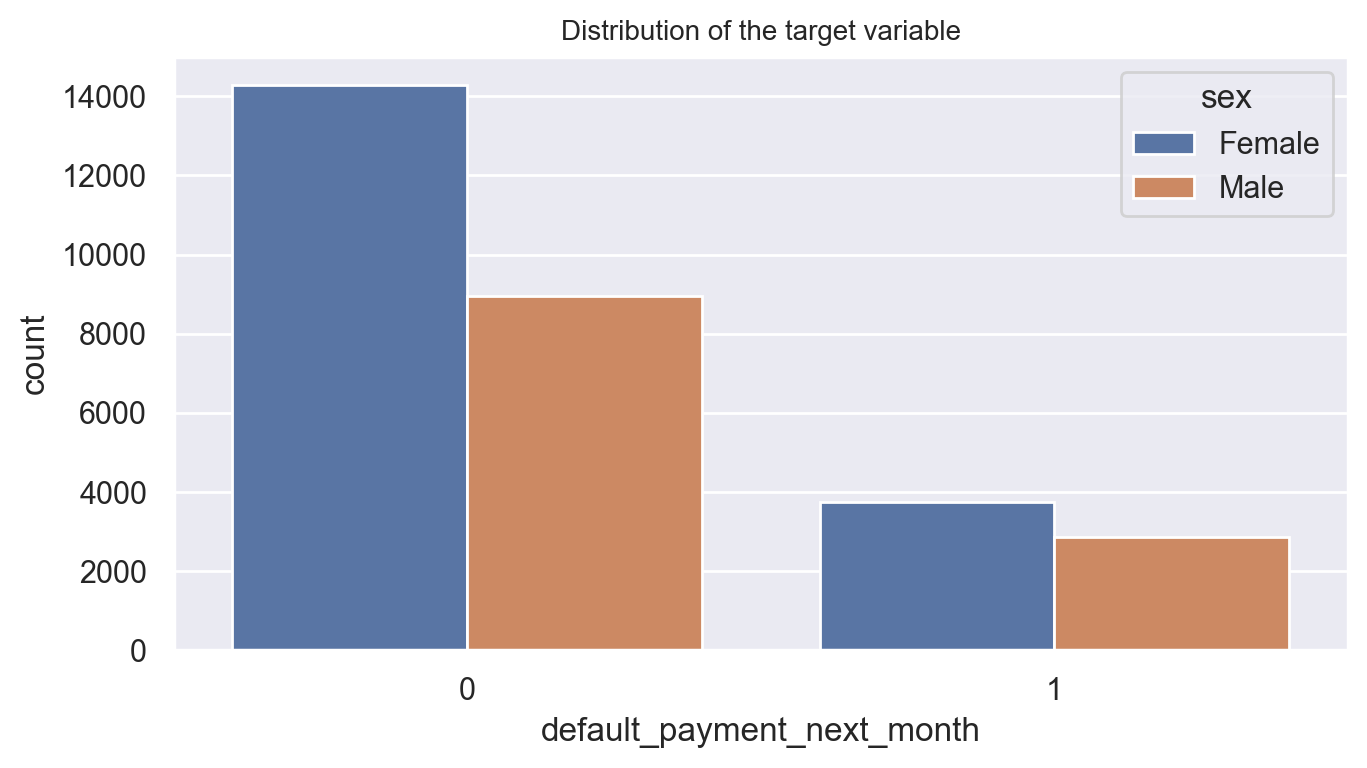

In [65]:
ax = sns.countplot(x='default_payment_next_month', hue='sex', 
                   data=df, orient='h')
ax.set_title('Distribution of the target variable', fontsize=10)

plt.tight_layout()
# plt.savefig('images/ch8_im9.png')
plt.show()

* 남성 고객의 경우 디폴트 비율이 더 높게 나온다

## 교육 수준별 디폴트를 조사 
* 그룹 간 백분율을 비교하는 것이 명목 값을 비교하는 것보다 쉬우므로 교육 수준별 기본값의 백분율을 도식화 
* 먼저 교육 수준별로 그룹화, 관심 변수를 선택한 다음, 그룹별 백분율(value_counts의 매개변수 normalize= True)을 계산하고 
* unstack을 진행하여 다중 인덱스를 제거한 뒤 plot으로 도식

In [66]:
df.groupby('education')['default_payment_next_month'] \
    .value_counts(normalize=True).unstack()

default_payment_next_month,0,1
education,,
Graduate school,0.808200,0.191800
High school,0.748874,0.251126
Others,0.929336,0.070664
University,0.762321,0.237679


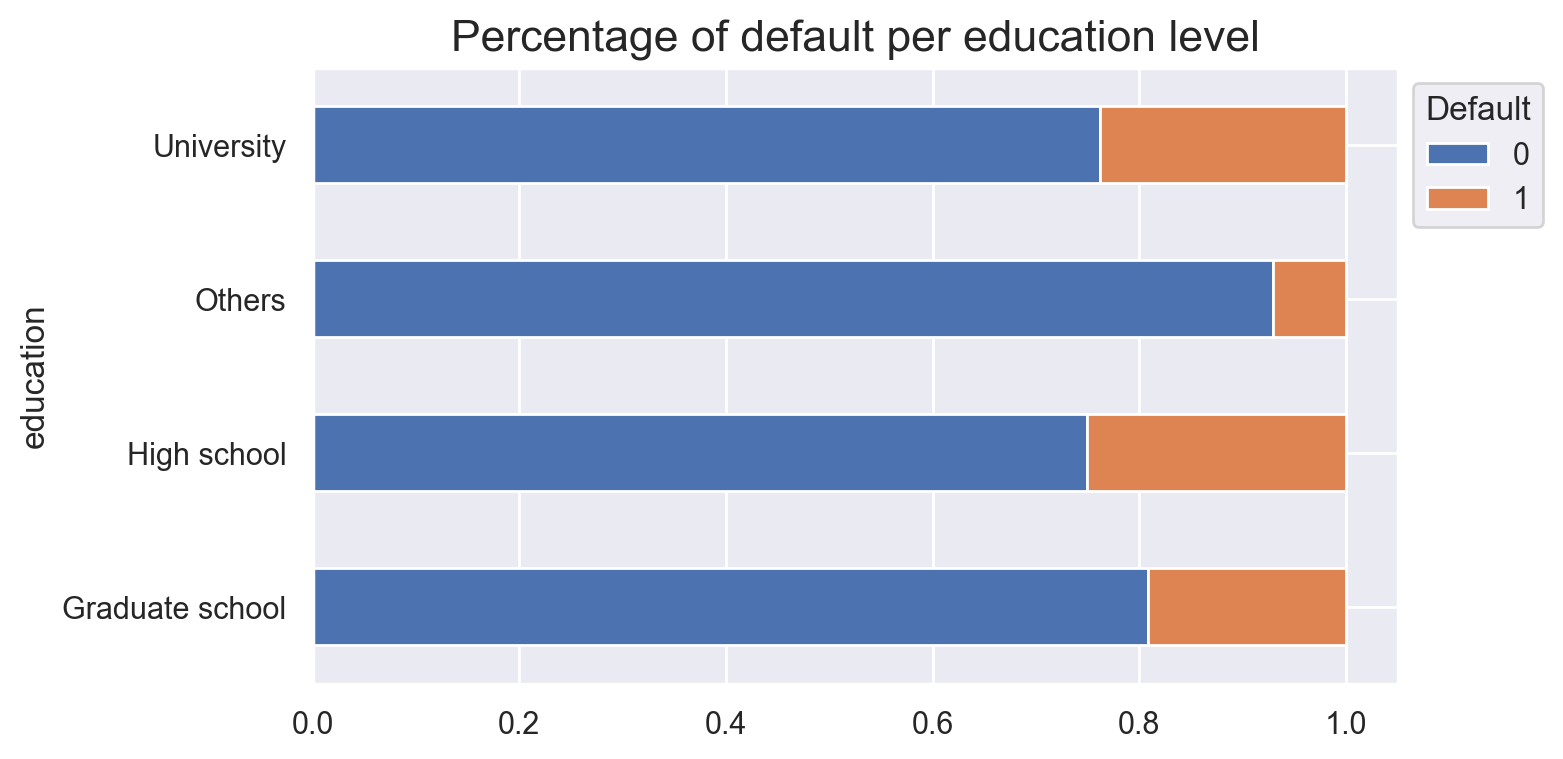

In [67]:
ax =  df.groupby('education')['default_payment_next_month'] \
       .value_counts(normalize=True).unstack().plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level', fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1))

* 상대적으로 대부분의 디폴트는 고졸 고객들 사이에서 발생하는 반면, 가장 적은 디폴트는 기타 범주에서 발생

## 정리 
* 기술 통계값으로 모든 숫자 변수의 개수, 평균, 최소/최대 및 사분위수와 같은 통계 값을 출력함. 
* 이러한 지표를 검사해 특정 특징의 값 범위 또는 분포가 왜곡됐는지 추정할 수 있음(평균값과 중앙값의 차이를 확인하여..)
* 또한 음수나 매우 작은 연령 등 가능한 범위를 벗어난 값을 쉽게 발견할 수 있음 

### EDA를 조금 더 쉽게 하기 
* pandas_profiling 라이브러리를 사용하여 단 한줄의 코드로 HTML보고서 형식으로 데이터셋에 대한 포괄적인 요약을 생성

pip install pandas_profiling

import pandas_profiling

df.profile_report()

# 훈련/테스트 데이터 나누기
* 훈련 집합 - 훈련용으로 나온 데이터를 사용하여 머신러닝 모델을 훈련한다. 
* 테스트 집합 - 이 데이터는 모델 훈련에는 사용해서 안 되며 성능 평가에만 이용해야 한다. 
* 데이터를 분할하는 목적은 과적합을 방지하고 모델의 성능을 평가하기 위한 목적
-----
### 주의할 점
* 훈련 단계에서 모델이 접근해서는 안 되는 정보를 관찰할 때 데이터 유출이 발생할 수 있다. 
* 예를 들면 전체 데이터를 읽고 결측치 처리시 평균으로 대치하는 경우이다. 
* 데이터를 분할하기 전에 이 작업을 수행했다면 테스트 집합의 데이터를 사용하고 평균을 계산해 데이터 유출을 초래했을 것이다. 
* 그렇기 때문에 먼저 데이터를 훈련과 테스트 집합으로 분할한 후 훈련 집합에서 관촬된 데이터를 사용해 훈련을 수행해야 한다. 
* 이 접근 방식은 새로운 데이터가 들어왓을 때 테스트 데이터셋과 동일한 방식으로 처리되므로 일관성이 보장된다. 

In [69]:
from sklearn.model_selection import train_test_split

## 데이터를 훈련과 테스트 집합으로 분할
* 데이터를 분할하는 방법에는 아래와 같이 정리할 수 있다. 
1. 데이터를 섞지(shuffle) 말고 훈련과 테스트로 분할(기본값은 데이터를 섞음)
2. 데이터를 층화(stratify)시키지 않고 훈련과 테스트 집합으로 분할
    * 훈련과 테스트 집합 모두 지정된 변수의 분포로 동일하게 분할 
    * 사기 감지의 경우와 같이 불균형 데이터를 처리할 때 매우 중요 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, stratify=y,
                                                    random_state=42)

In [71]:
print(X_train.shape, X_test.shape)

(24000, 23) (6000, 23)


In [72]:
print("Train->")
print(y_train.value_counts(normalize=True))
print("Test->")
print(y_test.value_counts(normalize=True))

Train->
default_payment_next_month
0    0.778792
1    0.221208
Name: proportion, dtype: float64
Test->
default_payment_next_month
0    0.778833
1    0.221167
Name: proportion, dtype: float64


## 검증 데이터가 필요한 경우 
* 검증 데이터 셋은 모델의 하이퍼파라미터를 찾을 때 사용된다. 
* 에를 들어 Decision Tree 모델을 튜닝할 때 max_depth같은 파라미터의 최적 값을 찾고 싶을 때 훈련 집합을 사용해 매번 다른 하이퍼파라미터 값으로 훈련을 진행하고 검증 데이터로 하이퍼파라미터의 값을 평가한다. 

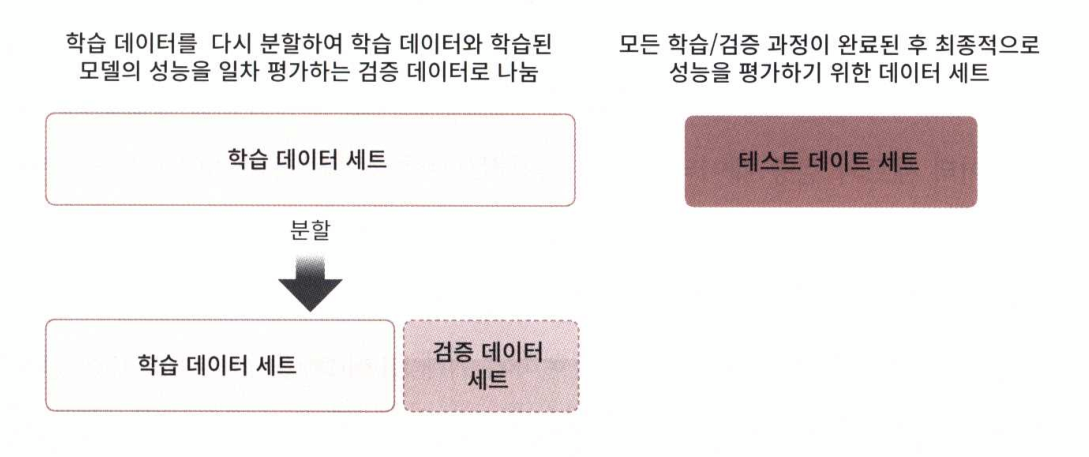

In [73]:
# 검증과 테스트 크기 정의 
VALID_SIZE = 0.1
TRAIN_SIZE = 0.7

# 훈련 데이터셋과 임시 데이터셋 생성 
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y, 
                                                    random_state=42)


# 새로운 테스트 데이터 셋의 크기 계산 
NEW_TEST_SIZE = 1-  ( X.shape[0] * 0.7 ) / (X_temp.shape[0])

# create the valid and test sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                    test_size=NEW_TEST_SIZE, 
                                                    stratify=y_temp)

In [74]:
print(X_train.shape, X_val.shape, X_test.shape)

(21000, 23) (3000, 23) (6000, 23)


# 결측값 처리

## 결측치 종류
### MCAR(Missing Completely At Random)
* 랜덤으로 완전 누락 
* 누락된 데이터의 이유는 나머지 데이터와 관련이 없다. 설문 조사에서 응답자가 실수로 질문을 놓친 예를 들 수 있다. 

### MAR(Missing At Random)
* 랜덤 결측
* 다른 열들의 데이터로부터 누락된 데이터를 유추 할 수 있다. 예를 들어, 특정 설문 조사 질문에 대한 응답 누락은 성별, 나이, 라이프스타일 등과 같은 다른 요인에 의해 조건부로 알아 낼 수 있다. 

### MNAR(Missing Not At Random)
* 임의가 아닌 결측
* 결측값에 대한 근본적인 이유가 있는 경우. 예를 들어, 소득이 매우 높은 사람들은 그것의 공개를 주저하는 경향이 있다. 

### 구조적으로 누락된 데이터 
* 대개 MNAR 하위 집합인 경우가 많으므로 논리적 이유로 데이터가 누락된다. 예를 들어, 배우자의 나이를 나타내는 변수가 없으면 배우자가 없는 것으로 추정할 수 있다. 

## 해법 
### 하나 이상의 결측값으로 관측값 삭제
* 이 방법이 가장 쉬운 방법이지만 특히 작은 데이터셋의 경우 항상 좋은 방법은 아니다.
* 결측값이 랜덤으로 되어 있을 경우 분석할 데이터가 작아질 수 있다. 
* 데이터가 무작위로 누락되지 않은 경우 분석에서 이러한 관측값을제거하면 결과에 편향이 생길수 있다. 
    
### 시계열을 처리하는 경우 채우기 
* 앞, 뒤의 데이터를 사용해서 채우거나, 보간법(선형)을 사용할 수 있다. 
    
### 결측값을 집계 지표로 대체한다. 
* 연속 데이터 경우 평균값(데이터에 명확한 이상치가 없는 경우) 또는 중앙값(이상치가 있는 경우)을 사용할 수 있다. 
* 범주형 변수의 경우 최빈값(집합에서 가장 일반적인 값)을 사용할 수 있다. 
* 단점은 데이터셋의 분산이 감소될 수 있다. 
    
### 결측값을 그룹별로 계산된 집계 지표로 대체
* 신체 관련 지표의 경우 결측치를 정교하게 대체하려면 성별로 평균값이나 중앙값을 사용할 수 있다. 
    
### ML-기반 방법 
* 특징을 타킷으로 간주하고 결측 관측값을 예측하고자 모델을 훈련시킬 수 있음 

## 결측치 처리 진행

pip install missingno

In [77]:
import pandas as pd 
import missingno
from sklearn.impute import SimpleImputer

### 결측치 개수 파악
* isnull 기능을 사용하여 결측치의 갯수를 파악할 수 있다.
* info 기능을 통해서 나온 값들은 결측치가 아닌 갯수가 출력되므로 결측치의 갯수를 역으로 파악할수 있다

In [78]:
X.isnull().sum()

limit_bal                 0
sex                     150
education               150
marriage                150
age                     150
payment_status_sep        0
payment_status_aug        0
payment_status_jul        0
payment_status_jun        0
payment_status_may        0
payment_status_apr        0
bill_statement_sep        0
bill_statement_aug        0
bill_statement_jul        0
bill_statement_jun        0
bill_statement_may        0
bill_statement_apr        0
previous_payment_sep      0
previous_payment_aug      0
previous_payment_jul      0
previous_payment_jun      0
previous_payment_may      0
previous_payment_apr      0
dtype: int64

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             30000 non-null  int64  
 1   sex                   29850 non-null  object 
 2   education             29850 non-null  object 
 3   marriage              29850 non-null  object 
 4   age                   29850 non-null  float64
 5   payment_status_sep    30000 non-null  object 
 6   payment_status_aug    30000 non-null  object 
 7   payment_status_jul    30000 non-null  object 
 8   payment_status_jun    30000 non-null  object 
 9   payment_status_may    30000 non-null  object 
 10  payment_status_apr    30000 non-null  object 
 11  bill_statement_sep    30000 non-null  int64  
 12  bill_statement_aug    30000 non-null  int64  
 13  bill_statement_jul    30000 non-null  int64  
 14  bill_statement_jun    30000 non-null  int64  
 15  bill_statement_may    30

### 결측치 시각화 하기
* missingno 패키지에서 흰색 막대는 결측값을 나타낸다. 
* 오른쪽에 있는 선은 데이터 완성도 형태를 나타낸다. 
* 두 숫자는 데이터셋의 최대와 최소 null을 나타낸다.(총 23개의 열이 있으며, 가장 누락된 값이 있는 행이 2개이므로 21개가 된다.)

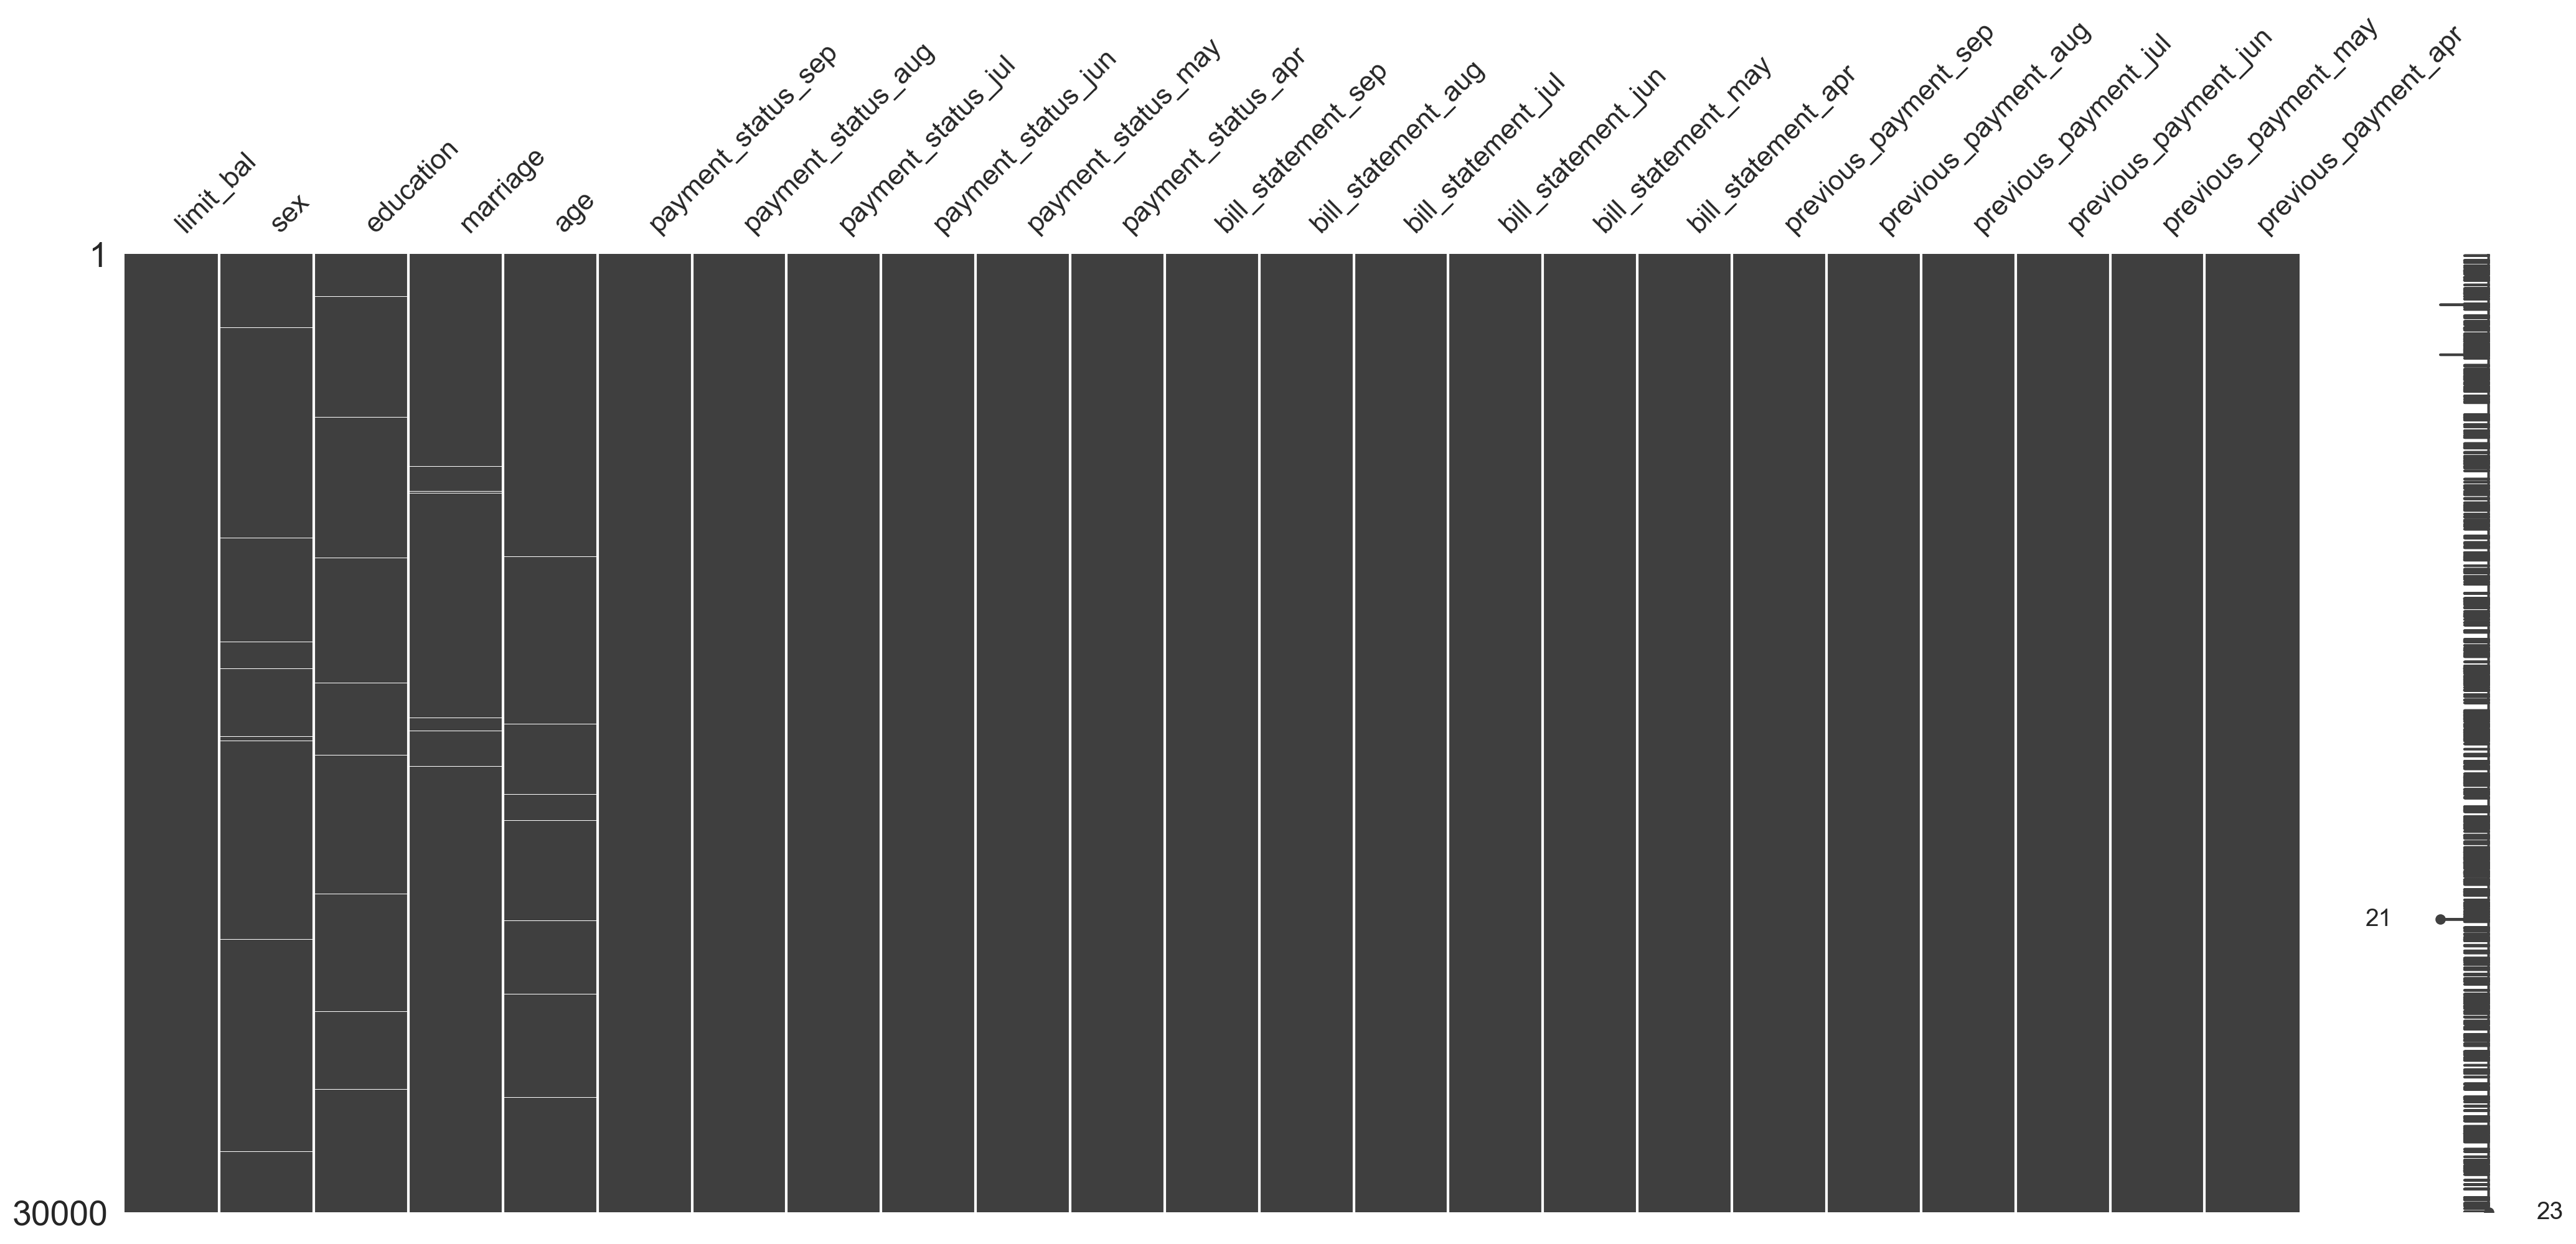

In [80]:
missingno.matrix(X)

# plt.savefig('images/ch8_im12.png')
plt.show()

* bar()를 사용하여 결측치가 아닌 데이터를 시각화하여 결측치의 분포를 확인할 수 도 있음

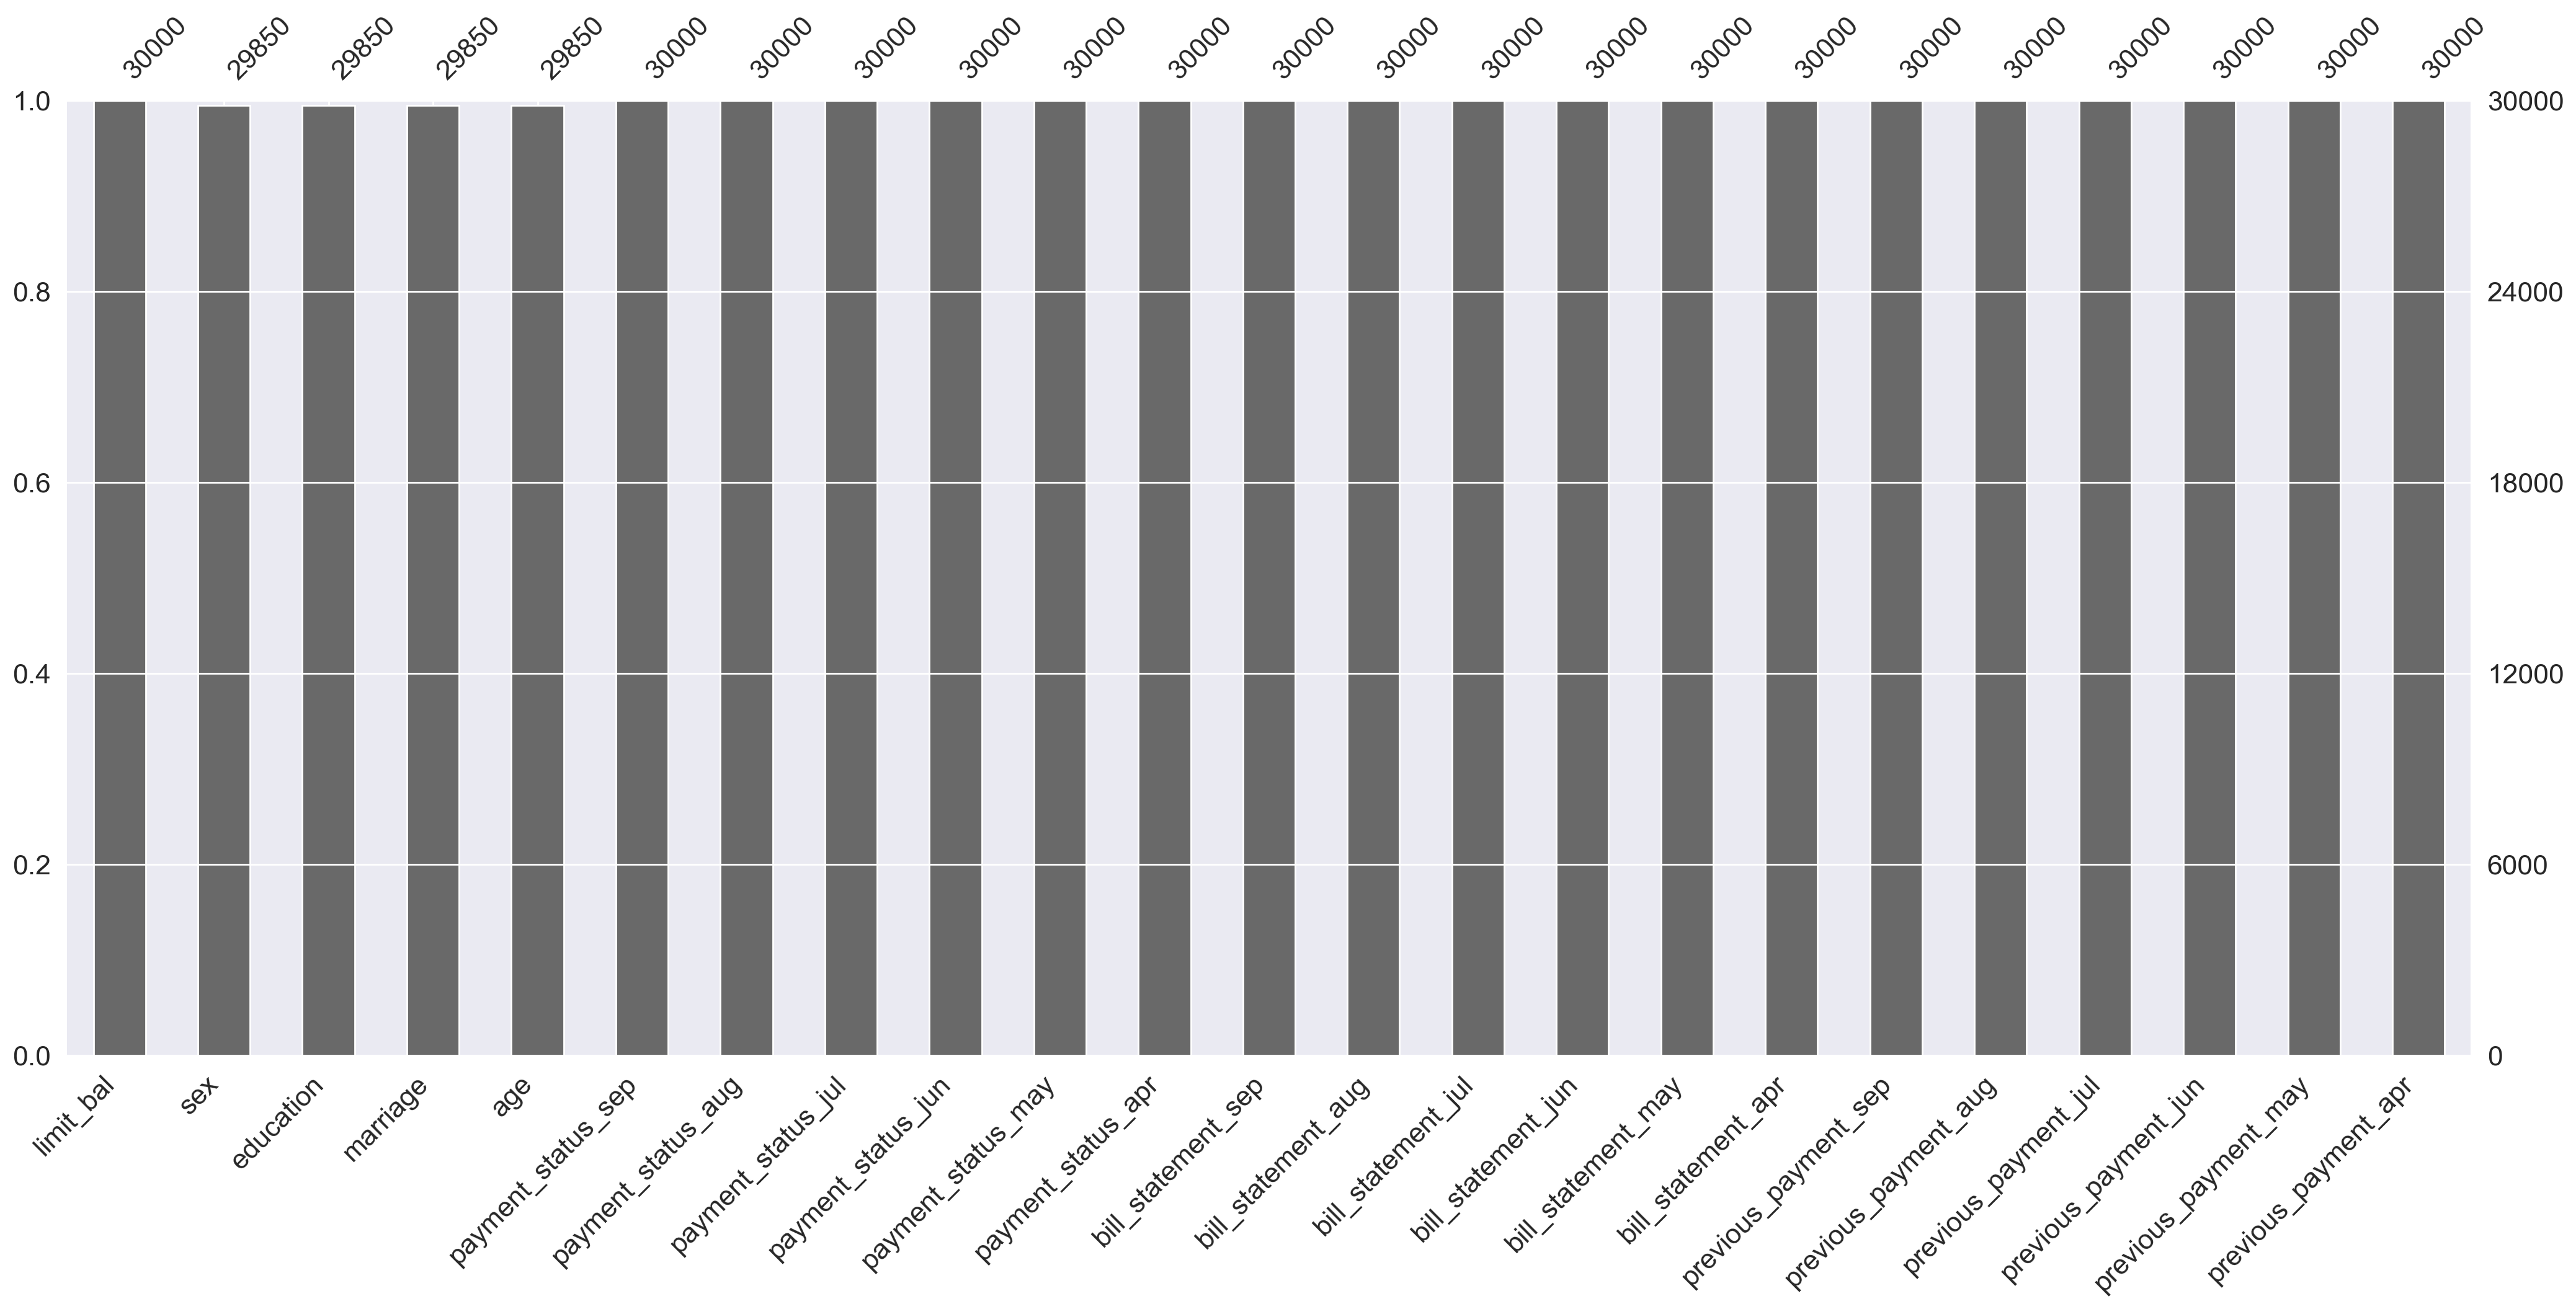

In [81]:
missingno.bar(X)

# plt.savefig('images/ch8_im12.png')
plt.show()

* 위의 그림을 바탕으로 유형별로 결측값이 있는 열을 정의

In [82]:
NUM_FEATURES = ['age']
CAT_FEATURES = ['sex', 'education', 'marriage']

### SimpleImputer 사용하여 값을 대체(수치형)
* 중앙값으로 대체

#### SimpleImputer 클래스 
* scikit-learn의 결측치를 처리하기 위한 클래스 
* 이름처럼 단순하게 결측치를 간단하게 처리 가능 
* strategy 파라미터는 결측치를 기본값으로 평균으로 대체하지만 아래 예제는 중앙값으로 대체 (mean, median, most_frequent, constant)

In [83]:
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

### SimpleImputer 사용하여 값을 대체(범주형)
    * 최빈값으로 대체

In [84]:
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

### 결측치 값 확인하기

In [85]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 21697 to 13005
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             21000 non-null  int64  
 1   sex                   21000 non-null  object 
 2   education             21000 non-null  object 
 3   marriage              21000 non-null  object 
 4   age                   21000 non-null  float64
 5   payment_status_sep    21000 non-null  object 
 6   payment_status_aug    21000 non-null  object 
 7   payment_status_jul    21000 non-null  object 
 8   payment_status_jun    21000 non-null  object 
 9   payment_status_may    21000 non-null  object 
 10  payment_status_apr    21000 non-null  object 
 11  bill_statement_sep    21000 non-null  int64  
 12  bill_statement_aug    21000 non-null  int64  
 13  bill_statement_jul    21000 non-null  int64  
 14  bill_statement_jun    21000 non-null  int64  
 15  bill_statement_may  

## 정리 
* **훈련 데이터의 주어진 컬럼**에 맞추고 훈련과 테스트 데이터에 적용 
* 위와 같은 방식으로 훈련 데이터만 사용해 중앙값을 추정해 잠재적인 데이터 유출을 방지 
* 결측값을 하나의 큰 값이나 평균값/중앙값/최빈값으로 바꾸는 것과 같은 접근 방식은은 결측값을 하나의 특정 값으로 대체하므로 단일 대치 방식이라고 한다. 
* 다중 배치 방식도 있으며 그중 하나는 연쇄 방정식에 의한 다중 대치(MICE, Multiple Imputation by Chanined Equantion)이며, 이 알고리즘은 다중 회귀 모델을 실행하며 각 결측값은 비결측 데이터 포인트를 기준으로 조건부로 결정 
* 이러한 머신러닝 기반 접근법을 사용해 결측치를 처리할 때 잠재적 이점은 단일 대치로 인한 평향의 감소이다. 
* scikit-learn에서는 IterativeImputer라는 이름으로 제공 

# 범주형 변수 인코딩

* 일부 변수들은 범주형 변수(DataFrame에서 object나 category로 표시되는 것들)인 것이 있음 
* 대부분의 머신러닝 알고리즘은 숫자 데이터로만 독점적으로 작동한다. 그렇기 때문에 범주형 특징을 모델과 호환되는 표현으로 인코딩(encoding)해야 한다. 

## 인코딩 방법
### label 인코딩 
    * 범주 값을 숫자로 대체 
    * 레이블 인코딩은 숫자로 대체되기 때문에 모델에서 크기를 인식할 수 있는 문제가 발생 
    * 국가 컬럼에 일본, 중국, 대한민국이 있다고 하면 레이블로 변경하면 0, 1, 2로 변경될수 있다. 
    * 이 값이 0 < 1 < 2 처럼 크기를 가지고 있는 데이터가 아니다. 
### one-hot 인코딩 
    * label 인코딩에서 인코딩 된 값의 크기의 문제를 극복하고자 one-hot 인코딩을 사용할 수 있다. 
    * 특징의 각 범주에 대해 이진 인코딩을 사용해 특정 행이 이 범주에 속하는지 여부를 나타내는 새 열(더미변수)을 만든다. 
    * 단점은 데이터셋의 차원이 크게 증가하기 때문에 차원의 저주에 걸릴수 있다. 
    
### 주의
* 레이블 인코딩을 사용때는 데이터에 잘못된 순서를 도입해서 잘못된 결론을 초래할 수 있는 열은 제외해야 한다. 
* Decision Tree 기반(랜덤 포레스트 게열도 포함)은 범주형 데이터와 레이블 인코딩 둘 다 사용 가능
* 선형 회귀, 거리 측정이 들어가는 알고리즘(K-Mean, K-NN), 인공 신경망은 원 핫 인코딩을 사용하는 것이 좋다 

## 범주형 변수 처리 

In [86]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

### 레이블 인코더를 사용해 선택된 변수를 인코딩

In [87]:
COL = 'education'

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

label_enc = LabelEncoder()
label_enc.fit(X_train_copy[COL])
X_train_copy.loc[:, COL] = label_enc.transform(X_train_copy[COL])
X_test_copy.loc[:, COL] = label_enc.transform(X_test_copy[COL])

### 원-핫 인코딩할 범주형 변수를 선택

In [88]:
CAT_FEATURES = X_train.select_dtypes(include='object') \
                      .columns \
                      .to_list()

In [89]:
CAT_FEATURES

['sex',
 'education',
 'marriage',
 'payment_status_sep',
 'payment_status_aug',
 'payment_status_jul',
 'payment_status_jun',
 'payment_status_may',
 'payment_status_apr']

### OneHotEncoder 객체를 인스턴스화
* 희소행렬로 작업하고 싶지 않다고 지정
* 특징별로 첫 번째 열을 삭제 
* 변환을 적용하는 동안 인코더가 알 수 없는 값을 찾은 경우 수행할 작업을 error로 지정

In [91]:
one_hot_encoder = OneHotEncoder(sparse_output=False, 
                                handle_unknown='error', 
                                drop='first')

### ColumnTransformer를 사용해 변환기를 생성
* 동일한 변환을 여러 열에 적용하는 편리한 방법 
* 지정된 열만 적용하고 아닌 열은 통과하는 remainder='passthrough'를 지정할 수 있음
* 기본값으로 drop으로 사용되지 않은 열이 삭제된다.

In [92]:
one_hot_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, CAT_FEATURES)]
    #,remainder='passthrough'
)

### 변환을 적용

In [93]:
one_hot_transformer.fit(X_train)

ColumnTransformer(transformers=[('one_hot',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['sex', 'education', 'marriage',
                                  'payment_status_sep', 'payment_status_aug',
                                  'payment_status_jul', 'payment_status_jun',
                                  'payment_status_may',
                                  'payment_status_apr'])])

### 변환기를 훈련과 테스트 집합 모두에 적용

In [101]:
col_names = one_hot_transformer.get_feature_names_out()

X_train_cat = pd.DataFrame(one_hot_transformer.transform(X_train), 
                           columns=col_names, 
                           index=X_train.index)
X_train_ohe = pd.concat([X_train, X_train_cat], axis=1) \
                .drop(CAT_FEATURES, axis=1)

X_test_cat = pd.DataFrame(one_hot_transformer.transform(X_test), 
                          columns=col_names, 
                          index=X_test.index)
X_test_ohe = pd.concat([X_test, X_test_cat], axis=1) \
               .drop(CAT_FEATURES, axis=1)

In [96]:
X_train_ohe.head(2)

,limit_bal,age,bill_statement_sep,bill_statement_aug,bill_statement_jul,bill_statement_jun,bill_statement_may,bill_statement_apr,previous_payment_sep,previous_payment_aug,...,one_hot__payment_status_may_Payment delayed 8 months,one_hot__payment_status_may_Unknown,one_hot__payment_status_apr_Payment delayed 2 months,one_hot__payment_status_apr_Payment delayed 3 months,one_hot__payment_status_apr_Payment delayed 4 months,one_hot__payment_status_apr_Payment delayed 5 months,one_hot__payment_status_apr_Payment delayed 6 months,one_hot__payment_status_apr_Payment delayed 7 months,one_hot__payment_status_apr_Payment delayed 8 months,one_hot__payment_status_apr_Unknown
21697,50000,25.0,38153,34476,25857,26621,27178,28038,1700,2000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
992,80000,27.0,57376,58649,59873,61077,62394,63655,2200,2200,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 참고

* pandas의 메서드를 사용해서 one-hot으로도 변경할 수 있다. 

### 타깃 인코딩 
* 분류 작업에 유용하며 종속 변수(y값)의 평균을 사용해 범주를 대체
* 평균 인코딩을 특징의 각 값에 조건화된 타깃 변수의 확률로 해석할 수 도 있음 
* 성별과 boolean(0,1) 타깃을 가진 단순 변수의 경우 타깃 인코딩은 범주를 성별당 양수의 비율로 대체

pip install category_encoders

In [99]:
import category_encoders as ce

In [100]:
target_encoder = ce.TargetEncoder(smoothing=0)
target_encoder.fit(X_train.sex, y_train)
target_encoder.transform(X_train.sex).head()

,sex
21697,0.206474
992,0.206474
10312,0.206474
1990,0.243835
8415,0.206474


* 훈련 집합에서 여성의 ~20.7%와 남성의 ~24.4%가 디폴트인 것처럼 보임 
* 정규화를 제거하고 순수한 평균값을 유지하고자 평활화 인수를 0으로 설정

### 타깃 인코딩의 장점
* 모델 성능 향상 
* 타깃 인코딩은 타킷 부류를 함게 그룹화하는 반면 레이블 인코딩의 경우 타깃 분포는 매우 임의적
* 변수의 수가 많은 원-핫 인코딩을 사용하는 대신 특징 수가 줄어든다. 이것은 gradient-boost된 트리에 특히 유용한데, 트리의 깊이가 제한돼 있기 대문에 카디널리티(cardinality) 범주 특징을 처리하는데 문제가 있기 때문이다. 

### 타깃 인코딩의 단점 
* 과적합(overfitting)을 유발할 수 있다는 점으로 해결책으로는 k-fold 타깃 인코딩을 적용할 수 있다. 

# Decision Tree 모델 만들기 
* Decision Tree의 특징으로 특정 값으로 반복해서 분할함으로써 특징 공간을 여러 개의 작은 영역으로 분할
* 이를 위해 그리디 알고리즘과 휴리스틱을 사용해 하위 노드의 결합된 불순물을 최소화하는 분할을 찾음(Gini 불순도 또는 엔트로피를 사용)

## 장점 
* 트리 형태로 쉽게 시각화 - 높은 해석력 
* 훈련이 빠르고 단계를 예측할 수 있음 
* 튜닝할 하이퍼파라미터가 적음
* 수치와 범주 특징을 모두 지원
* 비선형 데이터를 처리 
* 명시적 필요는 없지만 특징 가공 등을 통해 더 개설할 수 있는 여지가 있음
* 특징의 크기 조정이나 정규화가 필요 없음 
* 샘플을 분할할 특징을 선택함으로써 맞춤형 특징 선택 버전을 구현할 수 있음 
* 비모수적 모델 - x/y의 분포에 대한 가정이 없음
## 단점
* 불안정성 
    * 트리는 입력 데이터의 노이즈에 매우 민감. 데이터가 조금만 변경되면 모델이 크게 바뀔 수 있음 
* 과적합 
    * 최대값이나 정지 기준을 제공하지 않으며 Tree는 매우 깊게 자라며 일반화되지 않는 문제가 생김 
* 트리는 보간할 수 있지만 외삽할 수는 없다. 훈련 데이터의 특징 공간에 설정된 경계 영역을 벗어난 관측값에 대해서도 지속적으로 예측한다. 
* 기본 그리디 알고리즘은 전체적으로 최적의 의사결정 트리 선택을 보장하지 않는다. 
* 분류 불균형은 편향된 Tree로 이어질 수 있다. 
* 범주형 변수가 있는 Tree 모델에서는 정도 이득(엔트로피 감소)으로 인해 범주수가 많은 특징에 대해 펴향된 결과가 발생 

pip install pydotplus

pip install graphviz

In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from util import performance_evaluation_report
from io import StringIO
import seaborn as sns
from ipywidgets import Image
import pydotplus 
import graphviz

In [107]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train_ohe, y_train)
y_pred = tree_classifier.predict(X_test_ohe)

In [108]:
from sklearn.tree import export_graphviz

In [109]:
dt_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_clf.fit(X_train_ohe, y_train)



DecisionTreeClassifier(max_depth=3, random_state=42)

## Decision 모델의 시각화

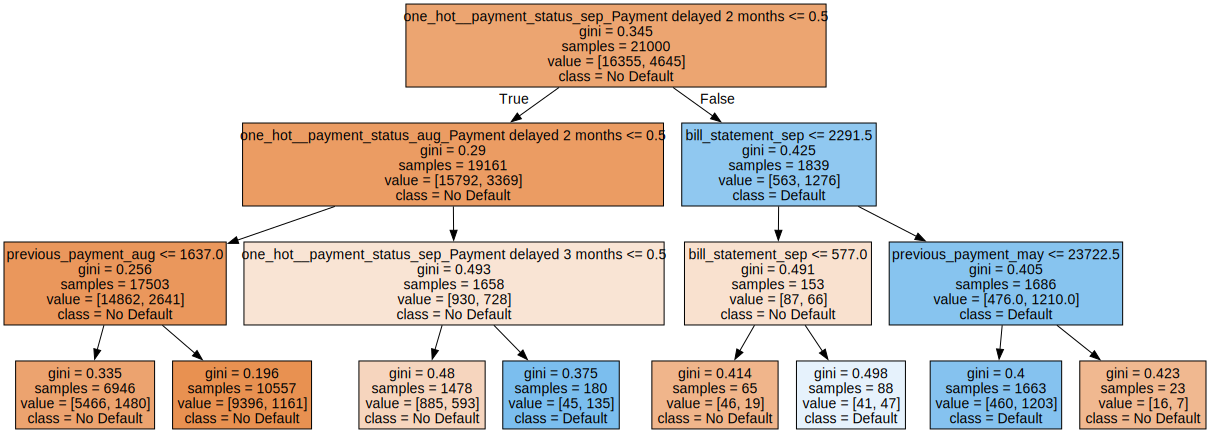

In [110]:
LABELS = ['No Default', 'Default']
export_graphviz(dt_clf, out_file='tree.dot', class_names = LABELS,
                feature_names=X_train_ohe.columns, impurity=True, filled=True)
with open("./tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

## confusion matrix
* TP(True Positive)  : 모델은 디폴트로 예측했고, 해당 사람은 디폴트를 했다. 
* FP(False Positive) : 모델은 디폴트를 예측했지만, 해당 사람은 디폴트를 하지 않았다. 
* TN(True Negative)  : 모델은 디폴트가 아니라고 예측했고, 해당 사람은 디폴트를 하지 않았다.
* FN(False Negative) : 모델은 디폴트가 아니라고 예측했지만, 해당 사람은 디폴트를 했다.  

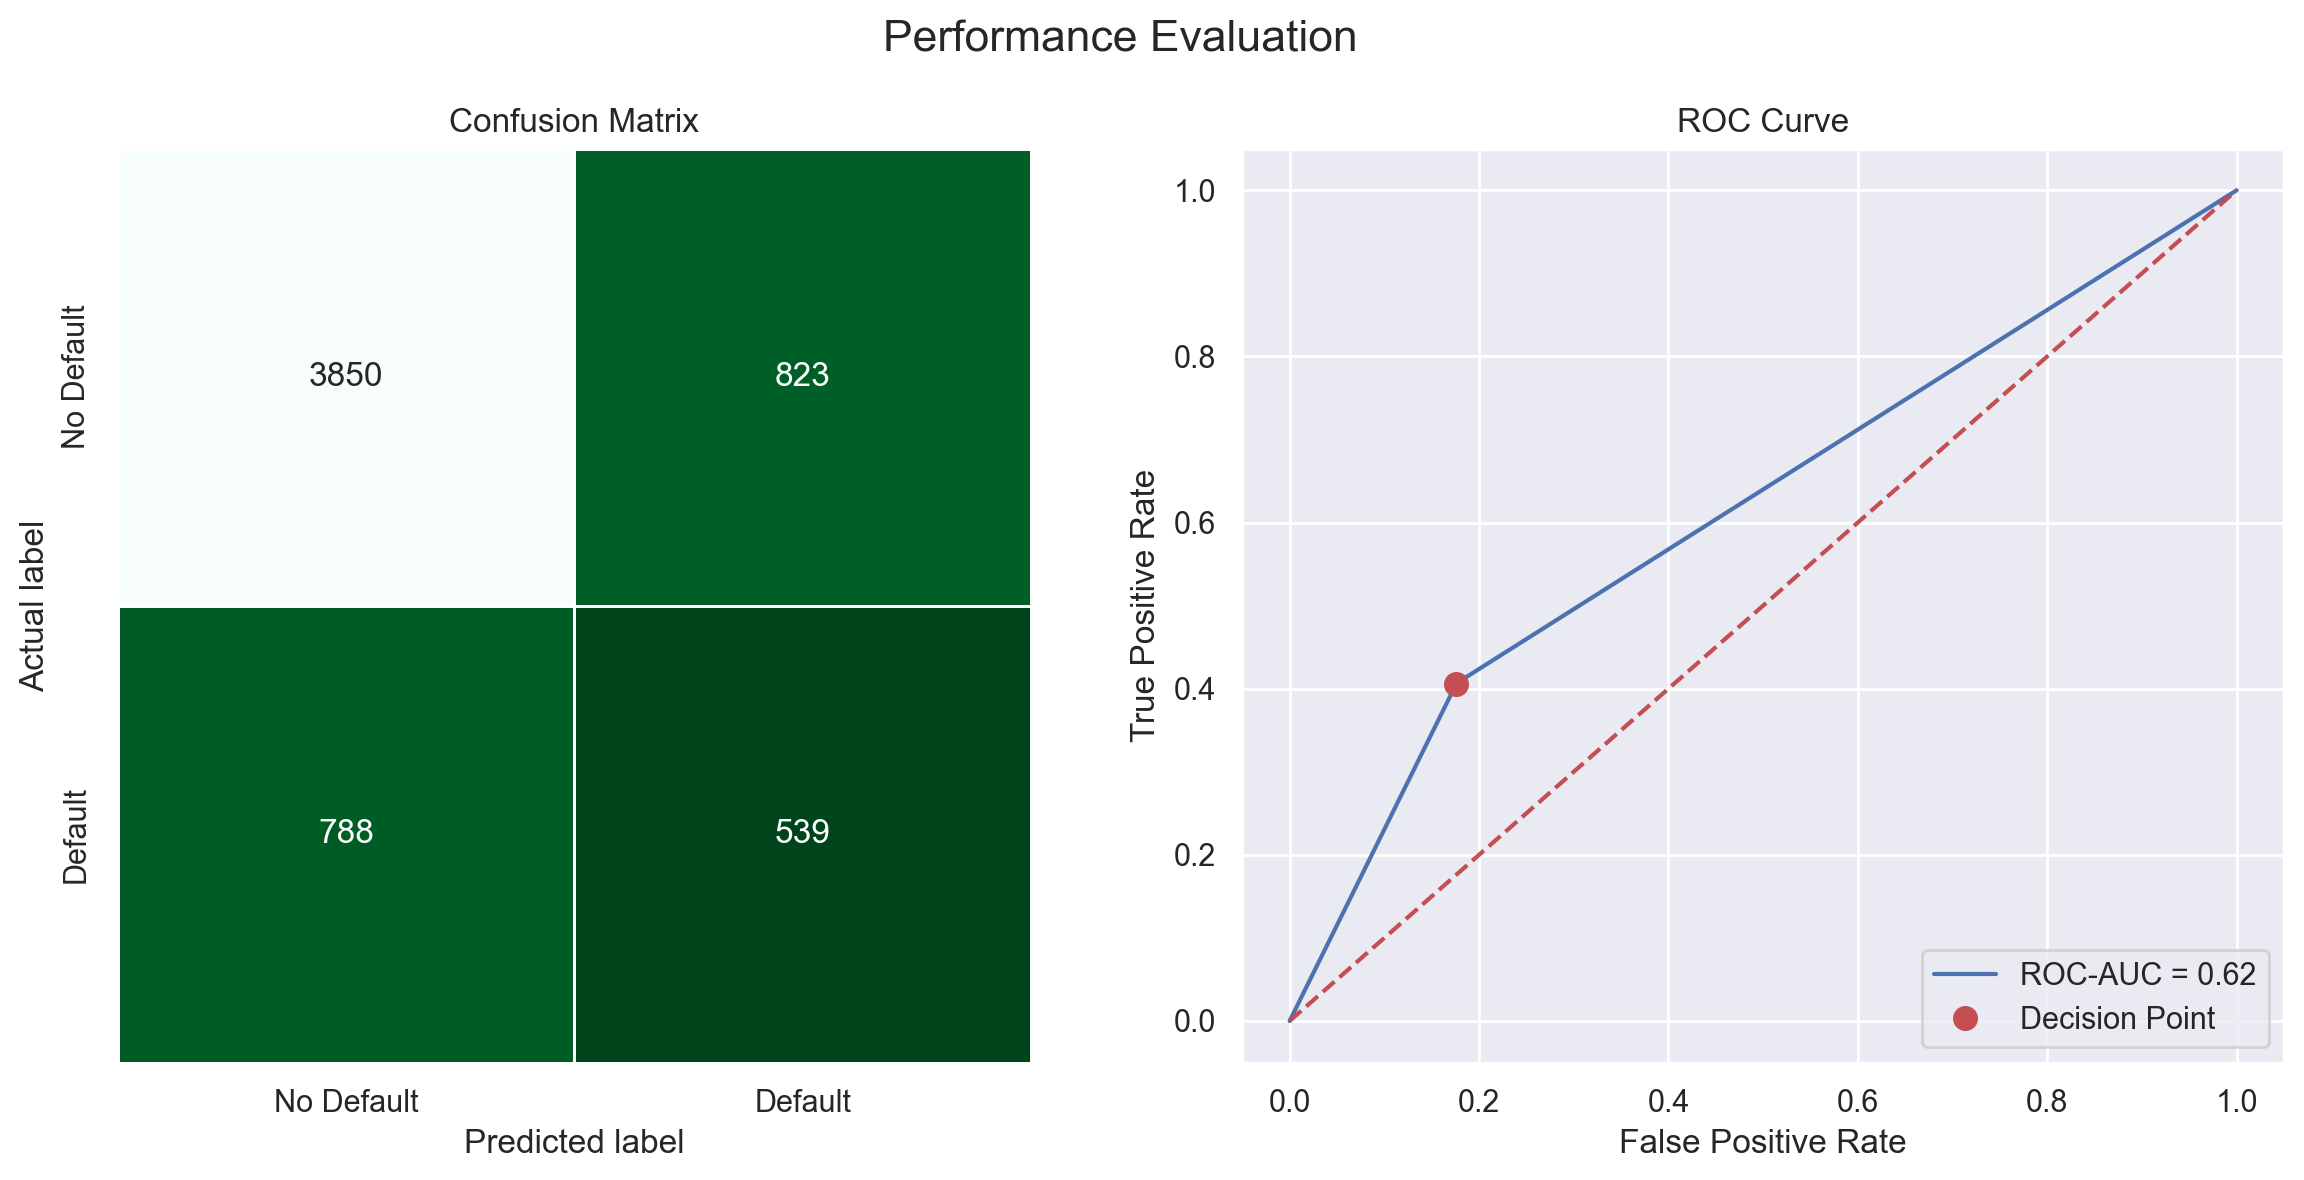

In [111]:
LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_classifier, 
                                          X_test_ohe, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im14.png')
plt.show()

In [112]:
tree_perf

{'accuracy': 0.7315,
 'precision': np.float64(0.3957415565345081),
 'recall': np.float64(0.40617935192162774),
 'specificity': np.float64(0.8238818745987588),
 'f1_score': np.float64(0.4008925251022685),
 'cohens_kappa': np.float64(0.22790914345361846),
 'roc_auc': np.float64(0.6151504312722754),
 'pr_auc': np.float64(0.466566186851522)}

* 정확도(accuracy)  : (TP + TN) / (TP + FP + TN + FN) - 모델의 전체  관측 능력을 정확하게 예측할 수 잇는 능력 
* 정밀도(precision) : TP / (TP + FP) - 양의 클래스에 대한 모든 예측 중에서 얼마나 많은 관측값이 디폴트가 되었는가? 
* 재현율(recall)    : TP / (TP + FN) - 모든 긍정 사례 중 몇 개가 올바르게 예측되었는가? 이는 민감도(sensitivity) 또는 참 긍정 비율(True Positive Rate)이라고도 한다.
* F-1 Score         : 정밀도와 재현율의 조화 평균값, 표준 평균 대신 조화 평균을 쓰는 이유는 정밀도 = 1, 리콜 = 0, 혹은 그 반대의 결과에 벌점을 주기 위해서다. 
* 특이성(specificity) : TN / (TN + FP) - 부정 사례(채무불이행을 하지 않은 고객)가 실제로 디폴트하지 않은 비율을 측정 
* FPR = FP / (FP + TN) = 1 - TNR = 1 - 특이성

## ROC
* Receiver Operating Characteristic 곡선
* 서로 다른 확률 임계값에 대해 참 긍정 비율과 거짓 긍정 비율(False Positive Rate) 간의 절충점을 나타낸다. 
* 확률 임계값은 예측이 긍정 부류에 속한다고 결정하는 예측 확률을 결정(기본값은 50%)
* 이상적인 점은 (0, 1)이며, 숙련된 모델의 곡선은 가능한 이 값에 가깝다. 그렇지 않은 모델은 대각선(45도)에 가까운 선이 된다. 
* 하나의 숫자로 모델의 성능을 요약하고자 ROC 곡선 아래 영역(AUC, Area Under the ROC curve)을 구한다. 이 값은 0.5와 1 사이의 값을 가진다. 
* 75%의 AUC는 예측에서 무작위로 2개의 관측 값을 취하면 75%의 확률로 올바른 방식으로 정렬됨을 의미 
* 또한 랜덤 모델은 50% 확률로 올바르게 정렬될 수 있으므로 최소 AUC는 0.5이다. 

### 불균형 데이터의 평가
* ROC 곡선은 부류 불균형을 처리할 경우에는 모델의 성능 평가 시 신뢰성을 잃어 버린다. 
* 그렇기 때문에 또 다른 곡선인 정밀도-재현율 곡선을 사용해야 한다. 
* 이는 정밀도와 재현율 계산 시 참 부정을 사용하지 않고 소수 부류(긍정 부류)의 정확한 예측만을 고려하기 때문에 

* 서로 다른 임계치에 대한 정밀도와 재현율을 계산 

In [113]:
y_pred_prob = tree_classifier.predict_proba(X_test_ohe)[:, 1]
precision, recall, thresholds = metrics.precision_recall_curve(y_test, 
                                                               y_pred_prob)

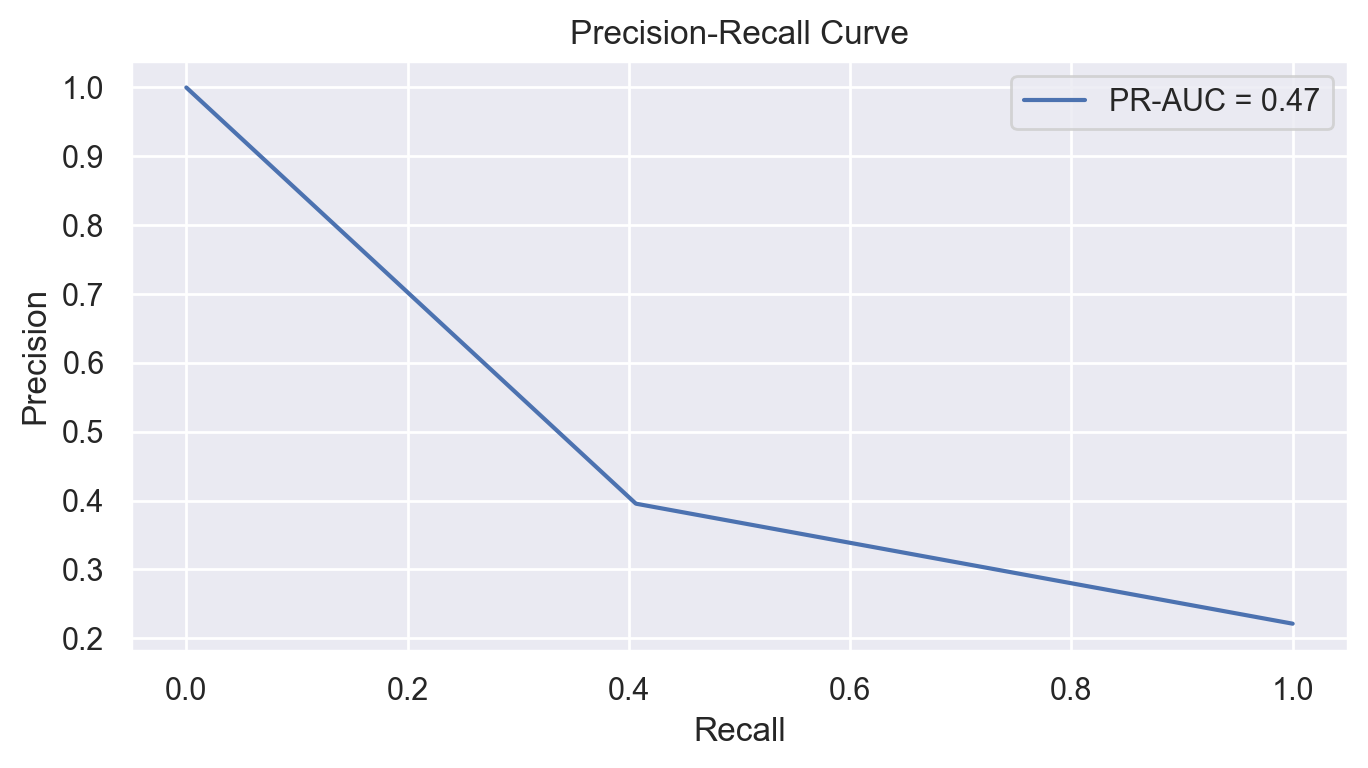

In [114]:
ax = plt.subplot()
ax.plot(recall, precision, 
        label=f'PR-AUC = {metrics.auc(recall, precision):.2f}')
ax.set(title='Precision-Recall Curve', 
       xlabel='Recall', 
       ylabel='Precision')
ax.legend()

plt.tight_layout()
# plt.savefig('images/ch8_im16.png')
plt.show()

* metrics.auc(recall, precision)를 호출해 정밀도-재현율 곡선 아래의 면적을 근사할 수 있다. 
* ROC-AUC와 달리 PR-AUC는 0에서 1까지이며, 1은 완벽한 모델을 나타낸다. 
* PR-AUC가 1인 모델은 모든 긍정 관측값(완전한 재현)을 식별할 수 있지만, 단일 부정 관측값을 긍정적으로 잘못 표시하지는 않는다.(완전한 정밀도) 
* (1,1)지점을 향해 내려가는 모델은 숙련된 것으로 간주할 수 있다. 

# scikit-learn의 파이프라인 구현 
* 파이프라인을 사용해 데이터 변환 목록을 순차적으로 적용한 다음 지정된 모델을 학습 
* 파이프라인의 중간 단계에 fit와 transform 메서드가 있어야 한다는 점

## 파이프라인의 이점 
* 흐름을 쉽게 읽고 이해할 수 있다. 주어진 열에 대해 실행할 연산의 체인이 명확하다. 
* 단계의 순서가 파이프라인에 의해 강제화된다. 
* 재현하기가 쉽다 

### 파이프라인 구현 

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from util import performance_evaluation_report
import matplotlib.pyplot as plt

1. 데이터 읽기 및 분할 

In [116]:
df = pd.read_csv('credit_card_default.csv', index_col=0, 
                 na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

2. 수치/범주 특징의 리스트 저장

In [117]:
num_features = X_train.select_dtypes(include='number') \
                      .columns \
                      .to_list()
cat_features = X_train.select_dtypes(include='object') \
                      .columns \
                      .to_list()

3. 수치 파이프라인을 정의 

In [118]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

4. 범주 파이프라인을 정의

In [120]:
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]

cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse_output=False, 
                             handle_unknown='error', drop='first'))
])

5. x변수 변환자 객체 정의 

In [121]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

6. 파이프라인을 결합

In [122]:
dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

In [123]:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['limit_bal', 'age',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_payment_aug',
                                                   'previous_payment_j...
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '7 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '5 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '8 '
                                                                                              'months']],
                                                                                 drop='first',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'education',
                                                   'marriage',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

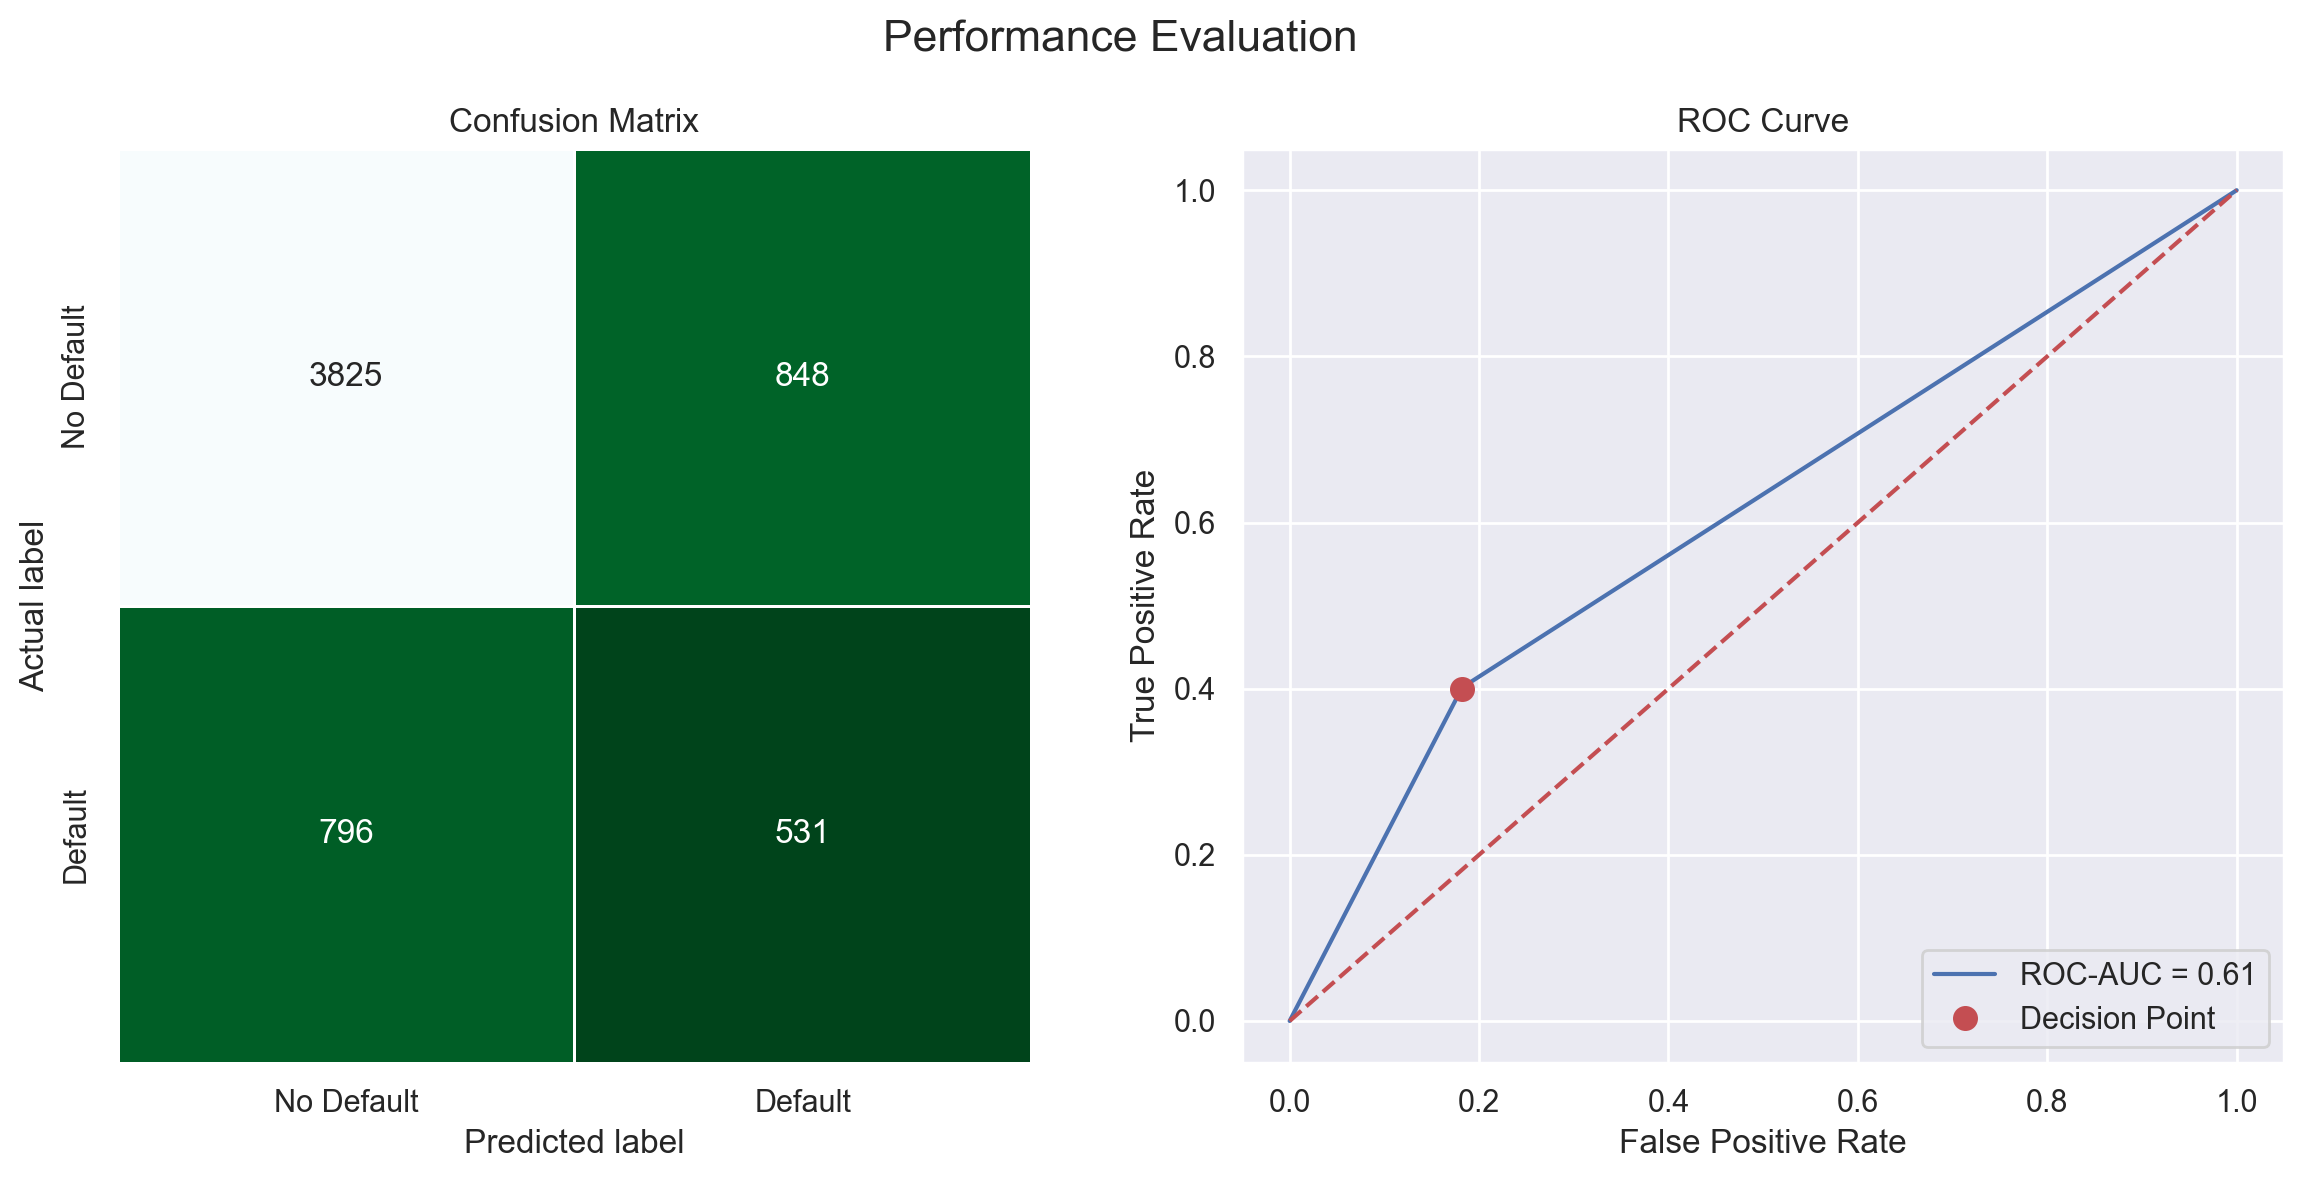

In [124]:
LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im17.png')
plt.show()

In [125]:
tree_perf

{'accuracy': 0.726,
 'precision': np.float64(0.38506163886874545),
 'recall': np.float64(0.40015071590052753),
 'specificity': np.float64(0.8185319922961695),
 'f1_score': np.float64(0.3924611973392461),
 'cohens_kappa': np.float64(0.21565721230387658),
 'roc_auc': np.float64(0.6096242084633444),
 'pr_auc': np.float64(0.45886981023398643)}

# 추가 사항
## 수치형 데이터의 스케일링 
* 상이한 특징은 서로 다른 척도로 측정된다는 사실로 인해 특징의 범위를 변경하는 것이다. 
* 이것은 모델에 편향을 유발할 수 있다. 특히 특징 간의 거리를 게산하는 모델(Knn)을 처리할 때는 스케일링에 주로 관심을 가져야 한다. 
* 일반적으로 Decision Tree를 기반으로 하는 방법에는 스케일링이 필요하지 않다. 
* scikit-learn에는 StandardScaler와 MinMaxScaler가 있다. 

## 연속 변수의 이산화 
* 연속 변수를 유한 개수의 bin(예 : 25이하, 25와 50 사이, 50이상)으로 변환할 수 있다. 
* 특정 bin을 만들려면 pd.cut 함수를 사용할 수 있지만, pd.qcut은 Quantile을 기준으로 분할하는데 사용된다. 

## 특이값 변환/제거
* EDA 중에는 종종 극단적인 값이 측정되는데 일종의 오류로 인해 발생할 수 있고, 혹은 단순히 나머지와 호환되지 않는(예: 일반 시민과 몇몇 재벌의 데이터) 경우가 있다. 
* 이러한 특이값은 모형의 결과를 왝곡시킬 수 있으므로 어떻게든 처리하는 것이 좋다. 
* 한 가지 해결책은 그것들을 제거하는 것이지만, 이것은 모델의 일반화 능력에 영향을 줄 수 있다. 
* 한편 그것들을 정규값에 더 가깝게 만들 수 도 있다. 
* 다음 예제에서는 특이값을 감지하고 수정하고자 사용자 정의 변환기를 작성하는 방법을 보여주고 있다. 
* 3 시그마 규칙을 적용해서 이상치를 처리한다. 

## 파이프라인을 위한 sklearn을 추가 

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

In [127]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

In [128]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())
])

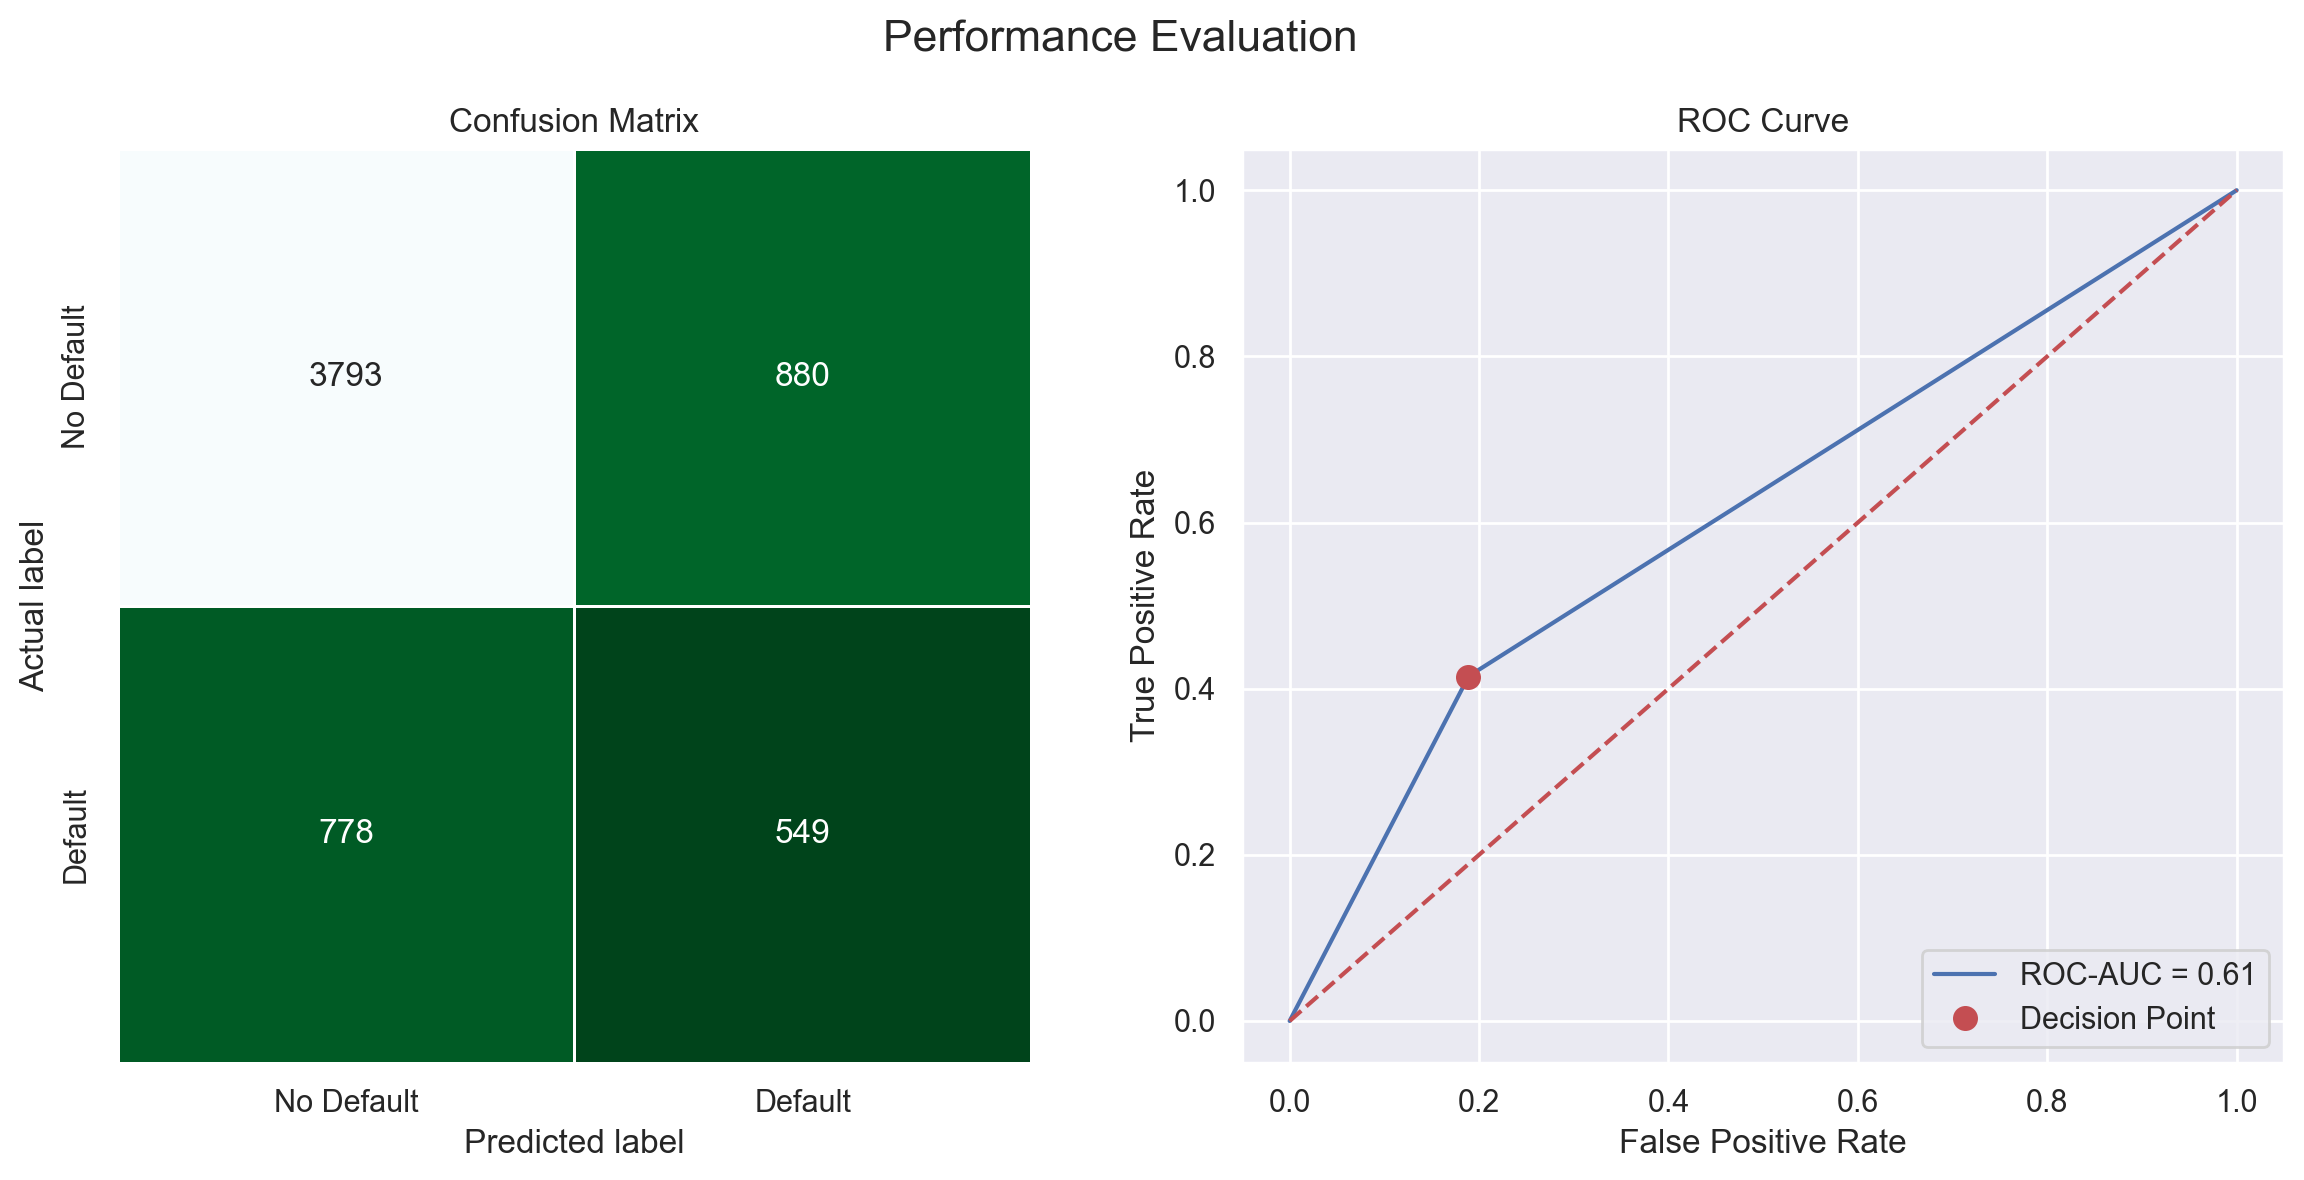

In [129]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im18.png')
plt.show()

In [130]:
tree_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outliers',
                                                                   OutlierRemover())]),
                                                  ['limit_bal', 'age',
                                                   'bill_statement_sep',
                                                   'bill_statement_aug',
                                                   'bill_statement_jul',
                                                   'bill_statement_jun',
                                                   'bill_statement_may',
                                                   'bill_statement_apr',
                                                   'previous_payment_sep',
                                                   'previous_pa...
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '7 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '5 '
                                                                                              'months',
                                                                                              'Payment '
                                                                                              'delayed '
                                                                                              '8 '
                                                                                              'months']],
                                                                                 drop='first',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'education',
                                                   'marriage',
                                                   'payment_status_sep',
                                                   'payment_status_aug',
                                                   'payment_status_jul',
                                                   'payment_status_jun',
                                                   'payment_status_may',
                                                   'payment_status_apr'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

* 해당 예제의 데이터에서는 특이값을 제한하는 변환을 포함해도 전체 성능에는 큰 영향이 없다.

# GridSearch 및 교차 검증 
## 하이퍼파라미터 
* 모델의 외부 특성을 나타낸다. 
* 데이터에 기반해 추정되지 않는다. 
* 모델의 설정으로 간주할 수 있다. 
* 훈련 단계 이전에 설정한다. 
* 조정을 통해 더 나은 성능을 얻을 수 있다. 

## 매개변수 
* 모델의 내부 속성을 나타낸다. 
* 데이터에 의해 추정된다. 예컨대 선형 회귀의 계수가 있다. 
* 훈련 과정을 통해 학습한다. 

## 교차검증(Cross-validation)
* 검증 데이터셋은 모델의 하이퍼파라미터를 조정하는데 사용된다. 
* 그러나 검증 셋을 만들려면 훈련과 테스트에 사용할 데이터가 희생되므로 소규모 데이터셋을 처리할 때는 데이터가 적어지는 문제가 있다. 
* 이때 사용할 수 있는 방법이 교차 검증이다. 


### K-fold 교차 검증

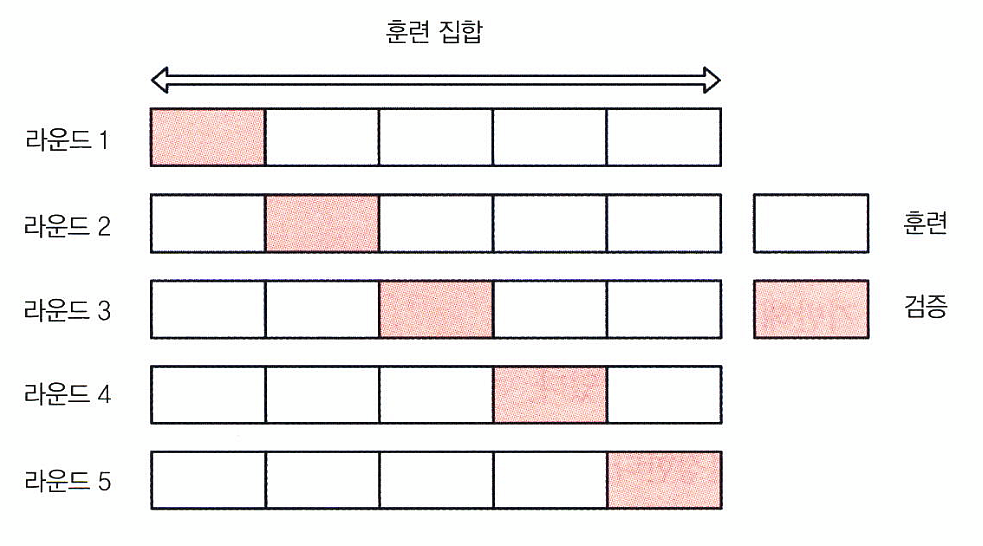

## GrdiSearch
* 모든 하이퍼파라미터를 조합하여 그리드를 생성하고 각각을 사용해 모델을 학습시키는 것 
* 완전 검색 덕분에 그리드 검색은 그리드 내에서 최적의 매개 벼수를 찾도록 보장한다. 
* 그러나 조건들이 많아 질수록 시간이 기하급수적으로 증가한다. 

## randomSearch
* 무작위로 하이퍼파라미터를 선택하여 모델을 학습하고 점수를 반환하며, 사전 정의된 반복 횟수나 계산 시간 제한에 도달할 때까지 전체 프로세스를 반복 
* 랜덤 검색이기 때문에 좋은 값을 찾기 위해서는 충분한 반복 횟수가 필요하다. 

### 교차검증 실습

In [131]:
from sklearn.model_selection import (GridSearchCV, cross_val_score, 
                                     RandomizedSearchCV, cross_validate, 
                                     StratifiedKFold)
from sklearn import metrics

In [132]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

In [133]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.72333333, 0.72375   , 0.71375   , 0.72854167, 0.72      ])

* 교차 검증에 평가 척도를 추가한다.

In [134]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, 
               scoring=['accuracy', 'precision', 'recall', 
                        'roc_auc'])

{'fit_time': array([0.32971215, 0.31921411, 0.31904221, 0.33277822, 0.30454302]),
 'score_time': array([0.02494693, 0.02503777, 0.02884674, 0.02429605, 0.02519011]),
 'test_accuracy': array([0.72333333, 0.72375   , 0.71375   , 0.72854167, 0.72      ]),
 'test_precision': array([0.38560411, 0.3862069 , 0.36978297, 0.39530843, 0.37674825]),
 'test_recall': array([0.42412818, 0.42184557, 0.41713748, 0.42843691, 0.40583804]),
 'test_roc_auc': array([0.61633282, 0.61553002, 0.60794039, 0.62188684, 0.60712913])}

### 그리드서치 실습

In [135]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
              'classifier__max_depth': range(3, 11),
              'classifier__min_samples_leaf': range(2, 11), 
              'preprocessor__numerical__outliers__n_std': [3, 4]}

In [136]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid, scoring='recall', 
                             cv=k_fold, n_jobs=-1, verbose=1)

classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/Users/gen2/miniconda3/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['limit_bal',
                                                                          'age',
                                                                          'bill_statement_sep',
                                                                          'bill_statement_aug',
                                                                          'bill_statement_jul',
                                                                          'bill_statement...
                                                                          'payment_status_jul',
                                                                          'payment_status_jun',
                                                                          'payment_status_may',
                                                                          'payment_status_apr'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': range(3, 11),
                         'classifier__min_samples_leaf': range(2, 11),
                         'preprocessor__numerical__outliers__n_std': [3, 4]},
             scoring='recall', verbose=1)

In [137]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 7, 'preprocessor__numerical__outliers__n_std': 4}
Recall (Training set): 0.3858
Recall (Test set): 0.3775


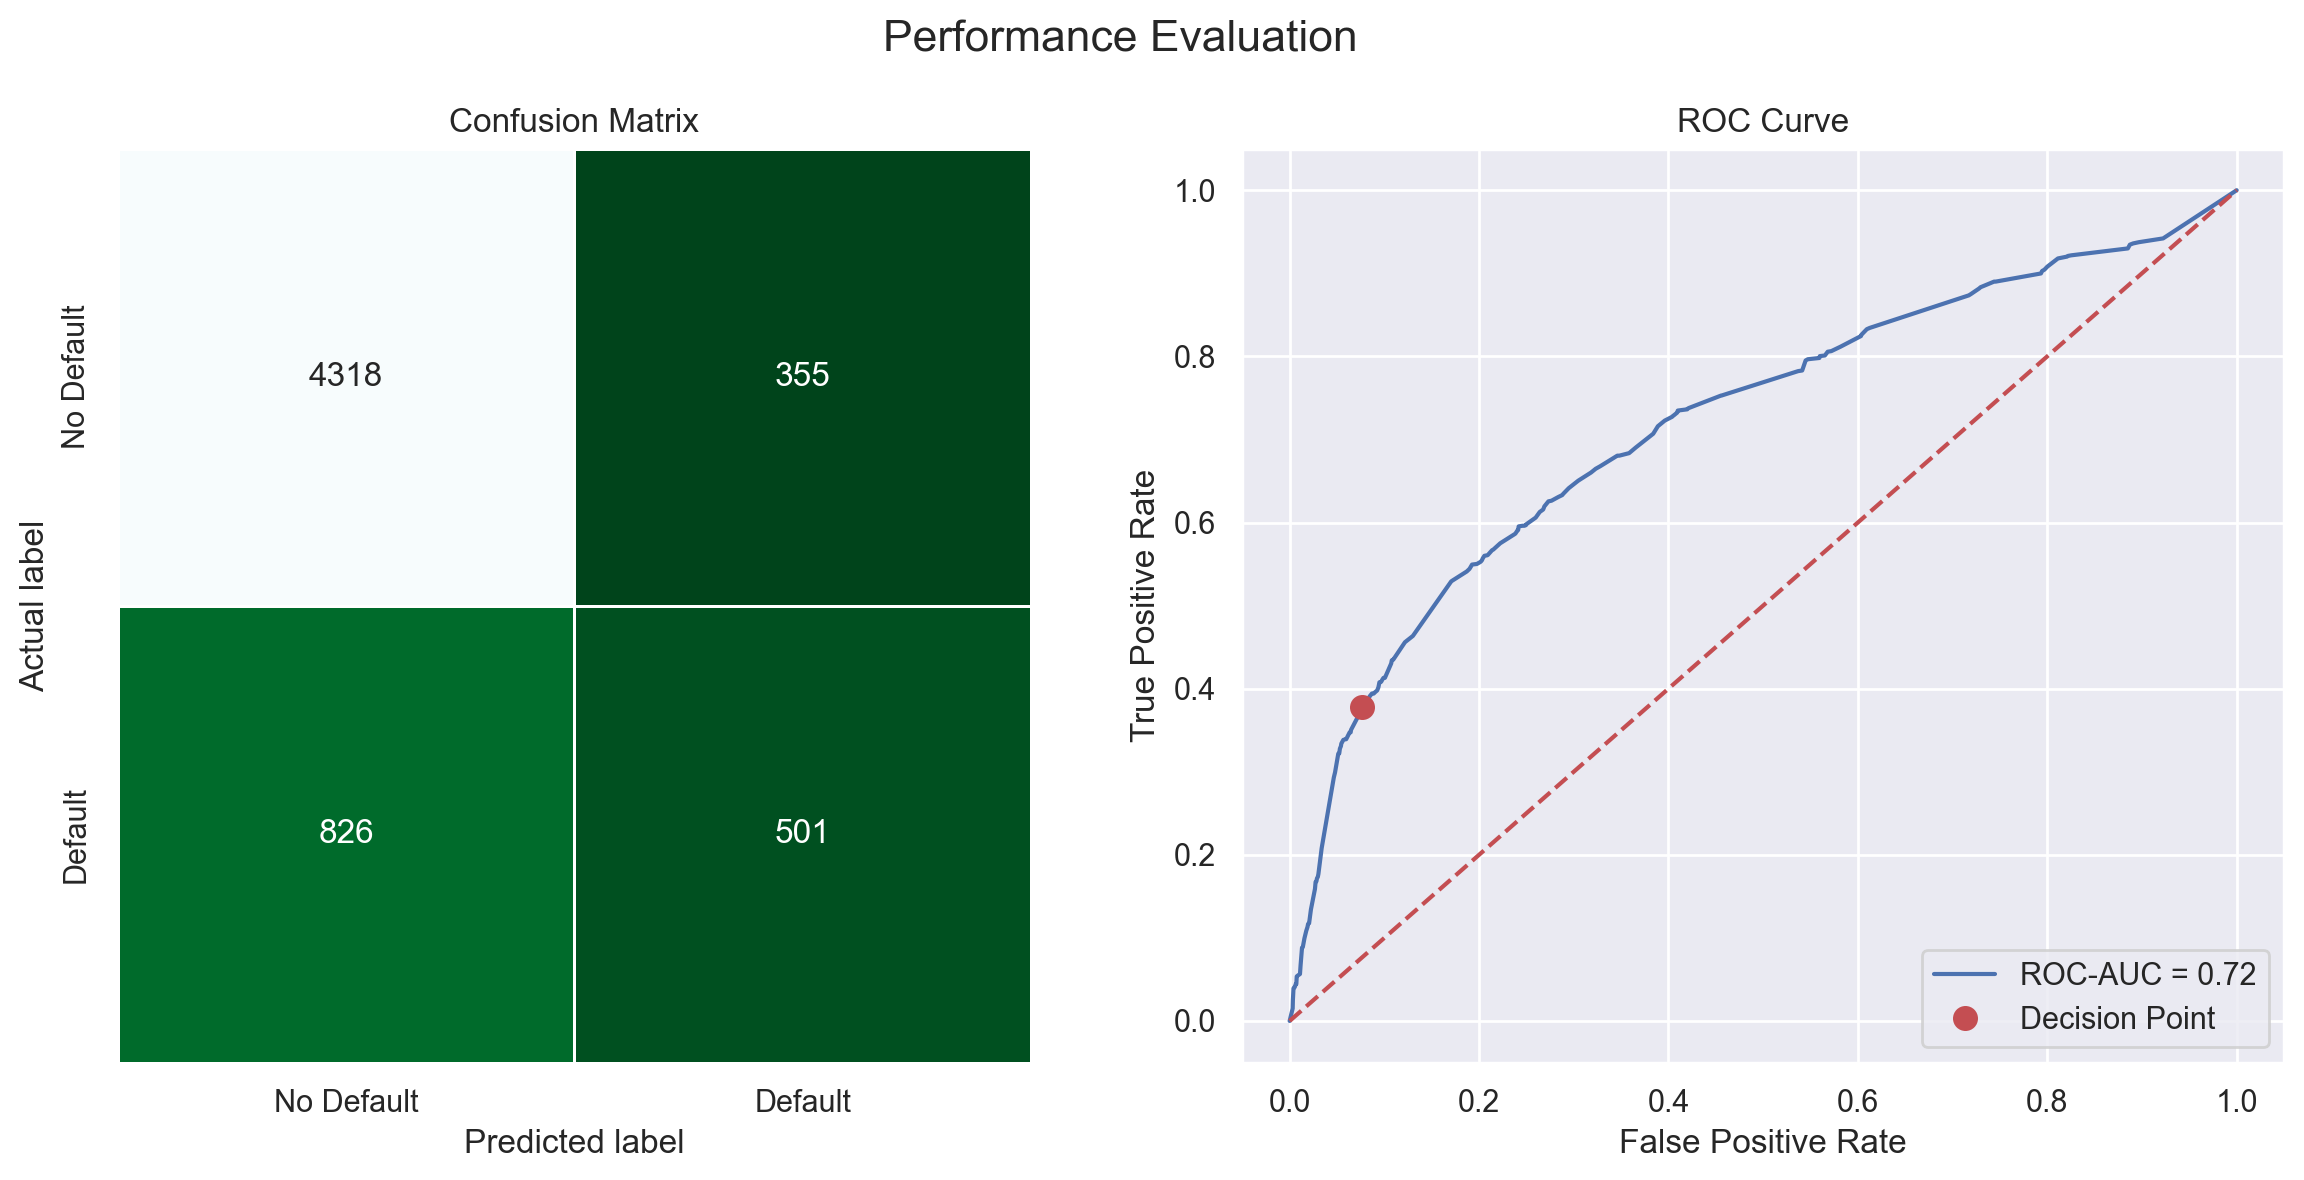

In [138]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im20.png')
plt.show()

### 랜덤서치 실습

In [ ]:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid, scoring='recall', 
                                   cv=k_fold, n_jobs=-1, verbose=1, 
                                   n_iter=100, random_state=42)
classifier_rs.fit(X_train, y_train)

In [ ]:
print(f'Best parameters: {classifier_rs.best_params_}') 
print(f'Recall (Training set): {classifier_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_rs.predict(X_test)):.4f}')

In [ ]:
tree_rs_perf = performance_evaluation_report(classifier_rs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im21.png')
plt.show()